In [1]:
import os, pandas as pd, numpy as np
import networkx, scprep, torch, phate
import matplotlib.pyplot as plt
import rpy2, rpy2.situation
from rpy2.robjects import r, pandas2ri

In [2]:
print(os.getcwd())
data_dir = f"{os.getcwd()}/data"
kge_dir = f"{os.getcwd()}/KGEs"

/var/home/ferran/PhD/yaleCollab


**Ligand** *(talking)* **-->** **Receptor** *(hearing)* **-->** **Target**[just genes for now] *(listening)*

With the interactions between nodes annotated with lvl3 Reactome pathways.
Build a directed knowledge graph that reflects the structure above.

* L-R interactions from NichetNet & cellchat (or anything else really)
* Target gene list from Nichenet too. 
* Pathways from Reactome. Define receptor/target-pathway edge based on ReactomeDB 

# Pathways

In [4]:
for i in rpy2.situation.iter_info(): # Print Rpy2 info
    print(i)

pandas2ri.activate()
%load_ext rpy2.ipython

rpy2 version:
3.5.11
Python version:
3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
Looking for R's HOME:
    Environment variable R_HOME: /var/home/ferran/miniconda3/envs/collab/lib/R
    Calling `R RHOME`: /var/home/ferran/miniconda3/envs/collab/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:

R version:
    In the PATH: R version 4.2.3 (2023-03-15) -- "Shortstop Beagle"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/var/home/ferran/miniconda3/envs/collab/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/var/home/ferran/miniconda3/envs/collab/lib', '/var/home/ferran/miniconda3/envs/collab/lib/R/lib', '/var/home/ferran/miniconda3/envs/collab/lib']
  extra_compile_args:
  ['-std=c99']
  extra_link_args:
  ['-Wl,--export-dynamic', '-fopenmp', '-Wl,-O2', '-

In [22]:
#LIst of pathways of interest (2nd level pathways)
dREACTpaths = pd.read_csv(f"{data_dir}/DBs/ReactomePathwaysRelation.txt", sep="\t", header=None)
dREACTpaths = dREACTpaths.loc[dREACTpaths[0].isin([
                "R-HSA-162582",#Signal transduction
                "R-HSA-5357801",#Programmed cell death
                "R-HSA-73894",#DNA repair
                "R-HSA-8953897",#Cell response to stress
                "R-HSA-1500931",#Cell-cell commns
                "R-HSA-1640170"#Cell cycle
                                                    ]),1]
dREACTpaths.shape

(35,)

In [23]:
dREACTpe = pd.read_csv(f"{data_dir}/DBs/Ensembl2Reactome_PE_All_Levels.txt", sep="\t", header=None)
dREACTpe = dREACTpe.loc[dREACTpe[0].str.startswith("ENSG")|dREACTpe[0].str.startswith("ENSP"),[1,2,3,5]].drop_duplicates()
dREACTpe = dREACTpe.loc[dREACTpe[3].isin(dREACTpaths)]
dREACTpe = dREACTpe.loc[dREACTpe[2].str.match("^\S*[A-Z0-9]+\S*[A-Z0-9]+(\sgene)?(\(\S+\))? \[")][[2,3,5]].dropna().drop_duplicates()
print(dREACTpe[3].nunique())
dREACTpe

35


2              3  \
1506579                   GCLC gene [nucleoplasm]  R-HSA-2262752   
1506580                            GCLC [cytosol]  R-HSA-2262752   
1506629                        NFYA [nucleoplasm]  R-HSA-2262752   
1506782                    CFTR [plasma membrane]  R-HSA-9716542   
1506783  CFTR [Golgi-associated vesicle membrane]  R-HSA-9716542   
...                                           ...            ...   
2045084               SCO2 [mitochondrial matrix]  R-HSA-2262752   
2045353                        miR-24-2 [cytosol]  R-HSA-2262752   
2045368                        miR-24-1 [cytosol]  R-HSA-2262752   
2052295                  NPBWR1 [plasma membrane]   R-HSA-372790   
2052313   UGT1A3 [endoplasmic reticulum membrane]  R-HSA-9006931   

                                                         5  
1506579                       Cellular responses to stress  
1506580                       Cellular responses to stress  
1506629                       Cellular responses to stress  
1506782  Signaling by Rho GTPases, Miro GTPases and RHO...  
1506783  Signaling by Rho GTPases, Miro GTPases and RHO...  
...                                                    ...  
2045084                       Cellular responses to stress  
2045353                       Cellular responses to stress  
2045368                       Cellular responses to stress  
2052295                                  Signaling by GPCR  
2052313                     Signaling by Nuclear Receptors  

[9408 rows x 3 columns]

# Ligand-Receptors

In [7]:
%%R -o dNNlr
#Directly load RDS object from NicheNet's zenodo repo
dNNlr = readRDS(url("https://zenodo.org/record/3260758/files/lr_network.rds"))

In [8]:
print("Ligand-Receptor\n",dNNlr.describe())
# print("TF-Target\n",dNNgr.describe())
# print("TF-Target 2\n",dNNgrt.shape,dNNgrt)
# print("Ligand-Target\n",dNNlt.shape,dNNlt)
dNNlr

Ligand-Receptor
          from     to  source        database
count   12651  12651   12651           12651
unique    688    857      14               5
top       AGT   FPR2  ppi_lr  ppi_prediction
freq      192     79    5956            6304


from         to              source           database
1        CXCL1      CXCR2      kegg_cytokines               kegg
2        CXCL2      CXCR2      kegg_cytokines               kegg
3        CXCL3      CXCR2      kegg_cytokines               kegg
4        CXCL5      CXCR2      kegg_cytokines               kegg
5         PPBP      CXCR2      kegg_cytokines               kegg
...        ...        ...                 ...                ...
12647    CXCL6       PIGR           ppi_lr_go  ppi_prediction_go
12648     RLN1      GPR25           ppi_lr_go  ppi_prediction_go
12649     RLN1      RAMP3           ppi_lr_go  ppi_prediction_go
12650   PIK3CB  TNFRSF10A      ppi_bidir_r_go  ppi_prediction_go
12651  PCDHGB1     PCDHA6  ppi_bidir_bidir_go  ppi_prediction_go

[12651 rows x 4 columns]

In [9]:
dCClr = pd.read_csv(f"{data_dir}/dCellChat_hsapiens.csv.tar.gz",header=None)
dCClr

0              1       2      3
0     TGFB1  LRinteraction  TGFBR1   TGFb
1     TGFB1  LRinteraction  TGFBR2   TGFb
2     TGFB2  LRinteraction  TGFBR1   TGFb
3     TGFB2  LRinteraction  TGFBR2   TGFb
4     TGFB3  LRinteraction  TGFBR1   TGFb
...     ...            ...     ...    ...
1976  VCAM1  LRinteraction   ITGA4   VCAM
1977  VCAM1  LRinteraction   ITGB1   VCAM
1978  VCAM1  LRinteraction   ITGA9   VCAM
1979  VCAM1  LRinteraction   ITGB7   VCAM
1980   VSIR  LRinteraction  IGSF11  VISTA

[1981 rows x 4 columns]

In [10]:
dNNlr = pd.DataFrame({
            "head":dNNlr["from"],
            "relation":np.repeat("LR", dNNlr.shape[0]),
            "tail":dNNlr["to"]
        })
dCClr = pd.DataFrame({
            "head":dCClr[0],
            "relation":np.repeat("LR", dCClr.shape[0]),
            "tail":dCClr[2]
        })
dLR = pd.concat([dNNlr, dCClr]).drop_duplicates().reset_index(drop=True)
del dNNlr,dCClr
dLR

head relation    tail
0      CXCL1       LR   CXCR2
1      CXCL2       LR   CXCR2
2      CXCL3       LR   CXCR2
3      CXCL5       LR   CXCR2
4       PPBP       LR   CXCR2
...      ...      ...     ...
12927   THY1       LR   ITGB2
12928   THY1       LR   ITGAX
12929   THY1       LR   ITGAV
12930   THY1       LR   ITGB3
12931   VSIR       LR  IGSF11

[12932 rows x 3 columns]

# Targets

In [11]:
%%R -o dNNgr
#Directly load RDS object from NicheNet's zenodo repo
dNNgr = readRDS(url("https://zenodo.org/record/3260758/files/gr_network.rds"))

In [12]:
print("Ligand-Target\n",dNNgr.describe())
dNNgr

Ligand-Target
            from       to              source        database
count   3592299  3592299             3592299         3592299
unique     4486    25103                  20               8
top         YY1   CDKN1A  harmonizome_ENCODE  harmonizome_gr
freq      47472      921             1564116         2953691


from       to                                 source  \
1          KLF2   DLGAP1                       harmonizome_CHEA   
2          KLF2     DTNB                       harmonizome_CHEA   
3          KLF2  BHLHE40                       harmonizome_CHEA   
4          KLF2  RPS6KA1                       harmonizome_CHEA   
5          KLF2      PXN                       harmonizome_CHEA   
...         ...      ...                                    ...   
3592295  ZNF461  CYP19A1  pathwaycommons_controls_expression_of   
3592296  ZNF467    PPARG  pathwaycommons_controls_expression_of   
3592297  ZNF521    BGLAP  pathwaycommons_controls_expression_of   
3592298  ZNF638    PPARG  pathwaycommons_controls_expression_of   
3592299   ZNFX1     TERT  pathwaycommons_controls_expression_of   

                          database  
1                   harmonizome_gr  
2                   harmonizome_gr  
3                   harmonizome_gr  
4                   harmonizome_gr  
5                   harmonizome_gr  
...                            ...  
3592295  pathwaycommons_expression  
3592296  pathwaycommons_expression  
3592297  pathwaycommons_expression  
3592298  pathwaycommons_expression  
3592299  pathwaycommons_expression  

[3592299 rows x 4 columns]

In [13]:
len(dNNgr["to"].unique())

25103

In [14]:
test0 = dNNgr.loc[dNNgr["from"].isin(dLR["head"])] #Filter to just targets of ligands in KG

test1 = test0.loc[test0["to"]!=test0["from"]] #Filter so that self targets do not count?

test2 = test0.loc[~test0["to"].isin(dLR["head"])&~test0["to"].isin(dLR["tail"])] #Filter so that targets cannot be ligands or receptors

In [15]:
test0

from      to                                 source  \
2112465    IL10   ESRRA               harmonizome_TRANSFAC_CUR   
2112466    IL10    PNOC               harmonizome_TRANSFAC_CUR   
2112467    IL10    WWC1               harmonizome_TRANSFAC_CUR   
2112468    IL10  ZBTB43               harmonizome_TRANSFAC_CUR   
2112469    IL10  TGFBR1               harmonizome_TRANSFAC_CUR   
...         ...     ...                                    ...   
3550998   POSTN   CXCL2  pathwaycommons_controls_expression_of   
3550999   POSTN     ELN  pathwaycommons_controls_expression_of   
3551000   POSTN   VEGFA  pathwaycommons_controls_expression_of   
3564738  SEMA4A   VEGFA  pathwaycommons_controls_expression_of   
3565345  SLURP1    CHAT  pathwaycommons_controls_expression_of   

                          database  
2112465             harmonizome_gr  
2112466             harmonizome_gr  
2112467             harmonizome_gr  
2112468             harmonizome_gr  
2112469             harmonizome_gr  
...                            ...  
3550998  pathwaycommons_expression  
3550999  pathwaycommons_expression  
3551000  pathwaycommons_expression  
3564738  pathwaycommons_expression  
3565345  pathwaycommons_expression  

[33842 rows x 4 columns]

In [16]:
test1

from      to                                 source  \
2112465    IL10   ESRRA               harmonizome_TRANSFAC_CUR   
2112466    IL10    PNOC               harmonizome_TRANSFAC_CUR   
2112467    IL10    WWC1               harmonizome_TRANSFAC_CUR   
2112468    IL10  ZBTB43               harmonizome_TRANSFAC_CUR   
2112469    IL10  TGFBR1               harmonizome_TRANSFAC_CUR   
...         ...     ...                                    ...   
3550998   POSTN   CXCL2  pathwaycommons_controls_expression_of   
3550999   POSTN     ELN  pathwaycommons_controls_expression_of   
3551000   POSTN   VEGFA  pathwaycommons_controls_expression_of   
3564738  SEMA4A   VEGFA  pathwaycommons_controls_expression_of   
3565345  SLURP1    CHAT  pathwaycommons_controls_expression_of   

                          database  
2112465             harmonizome_gr  
2112466             harmonizome_gr  
2112467             harmonizome_gr  
2112468             harmonizome_gr  
2112469             harmonizome_gr  
...                            ...  
3550998  pathwaycommons_expression  
3550999  pathwaycommons_expression  
3551000  pathwaycommons_expression  
3564738  pathwaycommons_expression  
3565345  pathwaycommons_expression  

[33834 rows x 4 columns]

In [17]:
test2

from       to                                 source  \
2112465    IL10    ESRRA               harmonizome_TRANSFAC_CUR   
2112467    IL10     WWC1               harmonizome_TRANSFAC_CUR   
2112468    IL10   ZBTB43               harmonizome_TRANSFAC_CUR   
2112471    IL10   ABLIM1               harmonizome_TRANSFAC_CUR   
2112473    IL10  PPP2R2B               harmonizome_TRANSFAC_CUR   
...         ...      ...                                    ...   
3514891     LCK      MYC  pathwaycommons_controls_expression_of   
3514893     LCK    SOCS3  pathwaycommons_controls_expression_of   
3550995   POSTN    ACTA2  pathwaycommons_controls_expression_of   
3550999   POSTN      ELN  pathwaycommons_controls_expression_of   
3565345  SLURP1     CHAT  pathwaycommons_controls_expression_of   

                          database  
2112465             harmonizome_gr  
2112467             harmonizome_gr  
2112468             harmonizome_gr  
2112471             harmonizome_gr  
2112473             harmonizome_gr  
...                            ...  
3514891  pathwaycommons_expression  
3514893  pathwaycommons_expression  
3550995  pathwaycommons_expression  
3550999  pathwaycommons_expression  
3565345  pathwaycommons_expression  

[26069 rows x 4 columns]

Carry on with the strictest subset, but interesting discussion on what to do next.

In [18]:
len(test2["to"].unique())

11519

# KG assembly

* Set of triples from L-R database:
    * Replicate triples for as many pathways are found to contain both Ligand and Receptor entities
* Set of triples from R-PTMs:
    * If Receptor and PTM in the same pathway, define triple with pathway edge annotation.


In [25]:
#Make df with only gene names. Group by pathway. IF both L and R in same group, we have a hit!
mdPathPE = dREACTpe.copy(deep=True)
mdPathPE[2] = mdPathPE[2].str.extract("^([A-Z0-9]+-*[A-Z0-9]+)")[0]
mdPathPE = mdPathPE.dropna().drop_duplicates()
mdPathPE = mdPathPE.groupby(by=[5])
mdPathPE.describe()

2                       \
                                                   count unique      top freq   
5                                                                               
Apoptosis                                            174    174      BAD    1   
Base Excision Repair                                  74     74     LIG3    1   
Cell Cycle Checkpoints                               259    259   MAD1L1    1   
Cell Cycle, Mitotic                                  517    517   MAD1L1    1   
Cell junction organization                            91     91   CLDN11    1   
Cellular responses to stress                         760    760     GCLC    1   
Chromosome Maintenance                               118    118   POLR2J    1   
DNA Damage Bypass                                     51     51    REV3L    1   
DNA Damage Reversal                                    8      8   ALKBH5    1   
DNA Double-Strand Break Repair                       153    153    RAD52    1   
Death Receptor Signaling                             153    153      BAD    1   
Fanconi Anemia Pathway                                38     38    ERCC1    1   
Integrin signaling                                    26     26   ITGA2B    1   
Intracellular signaling by second messengers         282    282      BAD    1   
MAPK family signaling cascades                       290    290   ITGA2B    1   
MTOR signalling                                       39     39    RRAGD    1   
Meiosis                                               84     84    BRCA1    1   
Mismatch Repair                                       15     15    POLD1    1   
Nephrin family interactions                           23     23      FYN    1   
Nucleotide Excision Repair                           120    120   POLR2J    1   
Regulated Necrosis                                    60     60    CFLAR    1   
Response to metal ions                                14     14     SNCB    1   
Signal regulatory protein family interactions         16     16    SKAP2    1   
Signaling by Erythropoietin                           22     22   PIK3CB    1   
Signaling by GPCR                                    694    694    WNT16    1   
Signaling by Hedgehog                                157    157  PRKAR2B    1   
Signaling by Hippo                                    20     20     DVL2    1   
Signaling by Leptin                                   11     11     JAK2    1   
Signaling by NOTCH                                   215    215   PLXND1    1   
Signaling by Non-Receptor Tyrosine Kinases            49     49    BCAR1    1   
Signaling by Nuclear Receptors                       257    257  CYP26B1    1   
Signaling by Receptor Tyrosine Kinases               511    511   POLR2J    1   
Signaling by Rho GTPases, Miro GTPases and RHOBTB3   678    678     CFTR    1   
Signaling by TGFB family members                     119    119    WWTR1    1   
Signaling by WNT                                     297    297      N4G    1   

                                                       3         \
                                                   count unique   
5                                                                 
Apoptosis                                            174      1   
Base Excision Repair                                  74      1   
Cell Cycle Checkpoints                               259      1   
Cell Cycle, Mitotic                                  517      1   
Cell junction organization                            91      1   
Cellular responses to stress                         760      1   
Chromosome Maintenance                               118      1   
DNA Damage Bypass                                     51      1   
DNA Damage Reversal                                    8      1   
DNA Double-Strand Break Repair                       153      1   
Death Receptor Signaling                             153      1   
Fanconi Anemia Pathway                

In [20]:
# %%time
# dLRpath = pd.DataFrame(columns=["head","relation","tail"])
# for i in dLR.iterrows():
#     for name, group in mdPathPE:
#         if any(group[2].str.contains(i[1]["head"])):
#             if any(group[2].str.contains(i[1]["tail"])):
#                 row = pd.Series({"head":i[1]["head"], "relation":name, "tail":i[1]["tail"]})
#                 dLRpath = pd.concat([dLRpath, row.to_frame().T])
# dLRpath = dLRpath.reset_index(drop=True)
# dLRpath.to_csv(f"{data_dir}/dLRpath.csv.tar.gz", index=False)

In [28]:
dLRpath = pd.read_csv(f"{data_dir}/dLRpath.csv.tar.gz")

In [22]:
dLRpath

head                                           relation   tail
0     CXCL1                                  Signaling by GPCR  CXCR2
1     CXCL2                                  Signaling by GPCR  CXCR2
2     CXCL3                                  Signaling by GPCR  CXCR2
3     CXCL5                                  Signaling by GPCR  CXCR2
4      PPBP                                  Signaling by GPCR  CXCR2
...     ...                                                ...    ...
9613  LAMA3                         Cell junction organization  ITGB4
9614  LAMB3                         Cell junction organization  ITGB4
9615    VWF                     MAPK family signaling cascades     GP
9616   CDH1                         Cell junction organization  ITGB1
9617   CDH1  Signaling by Rho GTPases, Miro GTPases and RHO...  ITGB1

[9618 rows x 3 columns]

Ingredients:

- List of targets from test2["to"]
- List of receptors from dLRpath["tail"]
- Genes grouped into pathways

Desire:

- If any combination of target and receptor belongs to the same pathway group, store the receptor, target and pathway name information


In [23]:
print(len(test2["to"].unique()))
print(len(dLRpath["tail"].unique()))

11519
413


In [24]:
%%time
dRTpath = pd.DataFrame(columns=["head","relation","tail"])

for name, group in mdPathPE:
    if any(test2["to"].isin(group[2])) & any(dLRpath["tail"].isin(group[2])):
        for r in group.loc[group[2].isin(dLRpath["tail"])][2].unique():
            for t in group.loc[group[2].isin(test2["to"])][2].unique():
                row = pd.Series({"head":r, "relation":name, "tail":t})
                dRTpath = pd.concat([dRTpath, row.to_frame().T])
        print(name)

dRTpath = dRTpath.dropna().drop_duplicates().reset_index(drop=True)
dRTpath.to_csv(f"{data_dir}/dRTpath.csv.tar.gz", index=False)

Apoptosis
Cell junction organization
Cellular responses to stress
Death Receptor Signaling
Integrin signaling
Intracellular signaling by second messengers
MAPK family signaling cascades
Nephrin family interactions
Regulated Necrosis
Signal regulatory protein family interactions
Signaling by Erythropoietin
Signaling by GPCR
Signaling by Hedgehog
Signaling by NOTCH
Signaling by Non-Receptor Tyrosine Kinases
Signaling by Nuclear Receptors
Signaling by Receptor Tyrosine Kinases
Signaling by Rho GTPases, Miro GTPases and RHOBTB3
Signaling by TGFB family members
Signaling by WNT
CPU times: user 1min 47s, sys: 104 ms, total: 1min 47s
Wall time: 1min 49s


In [30]:
dRTpath = pd.read_csv(f"{data_dir}/dRTpath.csv.tar.gz")

In [31]:
dRTpath

head          relation       tail
0       FAS         Apoptosis        BAD
1       FAS         Apoptosis      CFLAR
2       FAS         Apoptosis      PSMB1
3       FAS         Apoptosis      PSMC4
4       FAS         Apoptosis        BID
...     ...               ...        ...
87434  LGR4  Signaling by WNT  HIST1H2BO
87435  LGR4  Signaling by WNT  HIST1H2BH
87436  LGR4  Signaling by WNT      PSMB3
87437  LGR4  Signaling by WNT  HIST1H2BB
87438  LGR4  Signaling by WNT  HIST1H2AB

[87439 rows x 3 columns]

Assemble

In [27]:
dKGlrt = pd.concat([dLRpath, dRTpath]).drop_duplicates().reset_index(drop=True)

In [28]:
dKGlrt.to_csv(f"{data_dir}/dKGlrt.csv.tar.gz", index=False, header=False)

In [3]:
dKGlrt = pd.read_csv(f"{data_dir}/dKGlrt.csv.tar.gz", header=None)
dKGlrt

0                  1          2
0      CXCL1  Signaling by GPCR      CXCR2
1      CXCL2  Signaling by GPCR      CXCR2
2      CXCL3  Signaling by GPCR      CXCR2
3      CXCL5  Signaling by GPCR      CXCR2
4       PPBP  Signaling by GPCR      CXCR2
...      ...                ...        ...
97052   LGR4   Signaling by WNT  HIST1H2BO
97053   LGR4   Signaling by WNT  HIST1H2BH
97054   LGR4   Signaling by WNT      PSMB3
97055   LGR4   Signaling by WNT  HIST1H2BB
97056   LGR4   Signaling by WNT  HIST1H2AB

[97057 rows x 3 columns]

In [12]:
from itertools import product
import networkx as nx

def compute_hierarchy(G, metric="pykrack"):
    """
    Compute one of the possible hierarchy scores
    
    Parameters
    ----------
    G
        Directed NetworkX graph
    metric : str
        Type of hierarchy metric to compute. Accepted types are:
        'pykrack' for this module's implementation of the Krackhardt score.
        'rsnakrack' for the sna implementation in R.
        'hierarchy_flow' for the Luo and Magee 2011 as implemented in the NetworkX package.

    Returns
    -------
    score : float
        One of the possible hierarchy scores
    """

    #Ensure Graph is DirectedGraph
    if not G.is_directed():
        raise Exception
    #Ensure Graph is of DiGraph() format
    G = nx.DiGraph(G)

    if metric == "pykrack": #Python implementation
        #Compute transitive closure of graph to get the reachability graph
            #[contains an edge (i,j) if there is a path from i to j in the original graph]
        acyclic = 0
        try:
            nx.find_cycle(G)
        except:
            print("Acyclic graph")
            acyclic = 1
        if acyclic == 1:
            Gr = nx.transitive_closure_dag(G)
        else:
            Gr = nx.transitive_closure(G, reflexive=None)
        symmetric_dyads = 0
        non_null_dyads = 0
        n = len(Gr.nodes())
        #Count the number of non-null symmetric dyads
        for pair in product(Gr.nodes(), Gr.nodes()):
            if Gr.has_edge(pair[0],pair[1]) or Gr.has_edge(pair[1],pair[0]): #Non-null dyad
                non_null_dyads+=1
                if  Gr.has_edge(pair[0],pair[1]) == Gr.has_edge(pair[1],pair[0]): #Symmetric!
                    symmetric_dyads+=1
        #Raise exception if graph has no edges!
        if non_null_dyads == 0:
            raise Exception
        score = 1 - (symmetric_dyads / non_null_dyads)
    
    elif metric == "rsnakrack": #R implementation from the sna package
        try:
            base = importr("base")
            sna = importr("sna")
            score = sna.hierarchy(nx.to_numpy_array(G), measure="krackhardt")[0]
        except:
            print("R package sna was not found. Please install manually!")
            print("Computing hierarchy flow instead")
            snafail_flag = 1
            score = nx.flow_hierarchy(G)
    
    elif metric == "hierarchy_flow": #Networkx's hierarchy flow implementation
        score = nx.flow_hierarchy(G)

    # elif metric == "all": #This will eventually return a dict with all metrics

    else: # metric argument broken
        raise Exception



    return score

In [13]:
import networkx as nx

compute_hierarchy(networkx.from_pandas_edgelist(
    dKGlrt,
    source=0,target=2,
    edge_key=1,
    edge_attr=1,
    create_using=networkx.MultiDiGraph()))


0.9999681488087655

# KG networks

### As a multigraph in networtkX

Just to make degree plots

In [30]:
G = networkx.from_pandas_edgelist(
    dKGlrt,
    source=0,target=2,
    edge_key=1,
    edge_attr=1,
    create_using=networkx.MultiGraph())
G

In [31]:
print(f"Edges:{G.number_of_edges()}, Nodes:{G.number_of_nodes()}, Avg Degree:{sum(dict(G.degree()).values())/G.number_of_nodes()}")

Edges:97054, Nodes:2507, Avg Degree:77.42640606302353


In [32]:
print(f"Density of {networkx.density(G)}")
print("We have this many isolates: ", 
        networkx.number_of_isolates(G))
print("The graph is connected:",
        networkx.is_connected(G))

if not networkx.is_connected(G):
    print(f"\nWe have {networkx.number_connected_components(G)} connected subgraphs")
    
    Gcomponents = [G.subgraph(c).copy() for c in networkx.connected_components(G)]
    for i,g in enumerate(Gcomponents,start=1):
        print(f"Component {i}: Density of {networkx.density(g)}")
        print(f"Edges:{g.number_of_edges()}, Nodes:{g.number_of_nodes()}, Avg Degree:{sum(dict(g.degree()).values())/g.number_of_nodes()}")

Density of 0.030896411038716494
We have this many isolates:  0
The graph is connected: False

We have 5 connected subgraphs
Component 1: Density of 0.03111660333473026
Edges:97045, Nodes:2498, Avg Degree:77.69815852682146
Component 2: Density of 1.0
Edges:1, Nodes:2, Avg Degree:1.0
Component 3: Density of 2.0
Edges:6, Nodes:3, Avg Degree:4.0
Component 4: Density of 1.0
Edges:1, Nodes:2, Avg Degree:1.0
Component 5: Density of 1.0
Edges:1, Nodes:2, Avg Degree:1.0


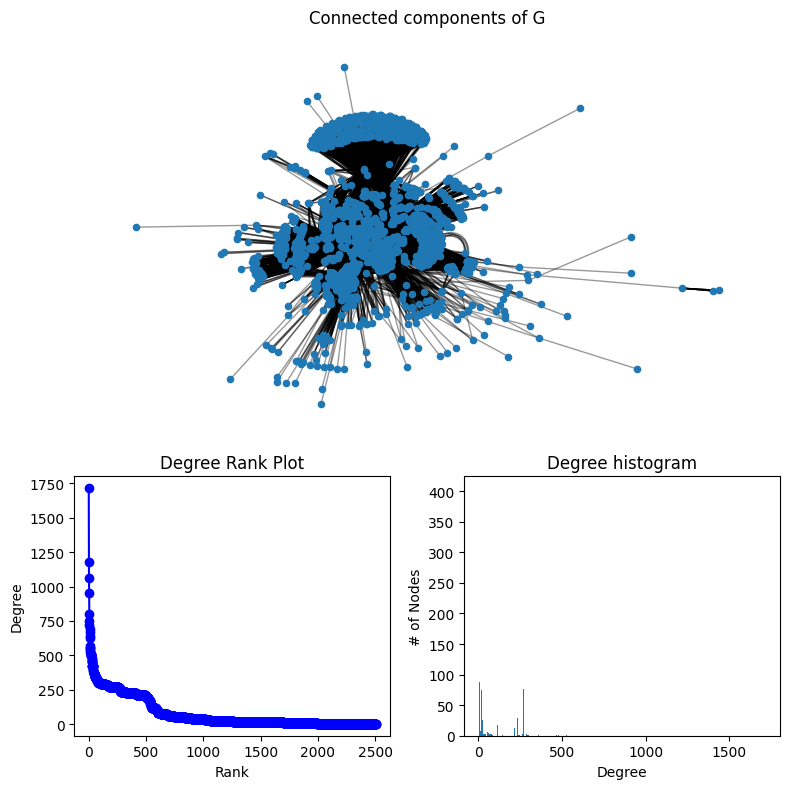

In [33]:
#Degree analysis: For directed graph it's the full graph -> no connected
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(networkx.connected_components(G), key=len, reverse=True)[0])
pos = networkx.spring_layout(Gcc, seed=10396953)
networkx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
networkx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

### As a multidigraph in NetworkX
Directed multigraph

In [8]:
G = networkx.from_pandas_edgelist(
    dKGlrt,
    source=0,target=2,
    edge_key=1,
    edge_attr=1,
    create_using=networkx.MultiDiGraph())
G

In [9]:
print(f"Edges:{G.number_of_edges()}, Nodes:{G.number_of_nodes()}, Avg Degree:{sum(dict(G.degree()).values())/G.number_of_nodes()}")
print("We have this many isolates: ", 
        networkx.number_of_isolates(G))

Edges:97057, Nodes:2507, Avg Degree:77.428799361787
We have this many isolates:  0


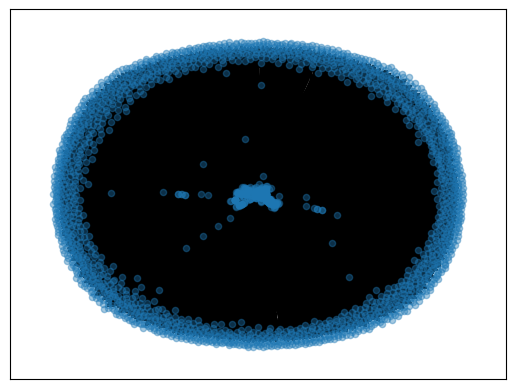

In [7]:
# networkx.draw_networkx(G=G, with_labels=False, node_size=20, alpha=0.4)

In [ ]:
# ax0 = fig.add_subplot(axgrid[0:3, :])
# Gcc = G.subgraph(sorted(networkx.connected_components(G), key=len, reverse=True)[0])
# pos = networkx.spring_layout(Gcc, seed=10396953)
# networkx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
# networkx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
# ax0.set_title("Connected components of G")
# ax0.set_axis_off()



# Embedding the KG

Use a KGE approach that takes into account directionality and multimodality


In [10]:
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory

In [12]:
dKGlrt.shape

(97057, 3)

In [13]:
tf = TriplesFactory.from_labeled_triples(
        dKGlrt.to_numpy(dtype="str"),create_inverse_triples=False)
tf

TriplesFactory(num_entities=2507, num_relations=23, create_inverse_triples=False, num_triples=97057)

In [14]:
import json
with open(f"{data_dir}/customLRT_KGEtransr_entityIDS.json","w") as outf:
    json.dump(tf.entity_id_to_label, outf)

with open(f"{data_dir}/customLRT_KGEtransr_relationIDS.json","w") as outf:
    json.dump(tf.relation_id_to_label, outf)

In [15]:
modelKGE = "customLRT_50_unstratified_stopped_TransR"

using automatically assigned random_state=959876817
No cuda devices were available. The model runs on CPU


Training epochs on cpu:   0%|          | 0/72 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
INFO:pykeen.evaluation.evaluator:Evaluation took 17.85s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.5073150628477231. Saved model weights to /var/home/ferran/.data/pykeen/checkpoints/best-model-weights-c4ad655c-e874-4d63-ad7e-5cd08c61a4ac.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
INFO:pykeen.evaluation.evaluator:Evaluation took 17.13s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.5170513084689883. Saved model weights to /var/home/ferran/.data/pykeen/checkpoints/best-model-weights-c4ad655c-e874-4d63-ad7e-5cd08c61a4ac.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.


Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
INFO:pykeen.evaluation.evaluator:Evaluation took 15.79s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.5521327014218009. Saved model weights to /var/home/ferran/.data/pykeen/checkpoints/best-model-weights-c4ad655c-e874-4d63-ad7e-5cd08c61a4ac.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
INFO:pykeen.evaluation.evaluator:Evaluation took 16.34s seconds


Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
INFO:pykeen.evaluation.evaluator:Evaluation took 17.03s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 50: 0.5599629095404904. Saved model weights to /var/home/ferran/.data/pykeen/checkpoints/best-model-weights-c4ad655c-e874-4d63-ad7e-5cd08c61a4ac.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 50.


Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
INFO:pykeen.evaluation.evaluator:Evaluation took 17.10s seconds


Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
INFO:pykeen.evaluation.evaluator:Evaluation took 16.94s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 70: 0.5672779723882134. Saved model weights to /var/home/ferran/.data/pykeen/checkpoints/best-model-weights-c4ad655c-e874-4d63-ad7e-5cd08c61a4ac.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 70.


Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/304 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/9.71k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 18.26s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=2507, num_relations=23, create_inverse_triples=False, num_triples=77645) to file:///var/home/ferran/PhD/yaleCollab/KGEs/customLRT_50_unstratified_stopped_TransR/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///var/home/ferran/PhD/yaleCollab/KGEs/customLRT_50_unstratified_stopped_TransR


TransR(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): TransRInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(2507, 50)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(23, 30)
    )
    (1): Embedding(
      (_embeddings): Embedding(23, 1500)
    )
  )
  (weight_regularizers): ModuleList()
)
CPU times: user 45min 41s, sys: 33.2 s, total: 46min 14s
Wall time: 5min 50s


<Axes: title={'center': 'Early Stopper Evaluation Plot'}, xlabel='Epoch', ylabel='hits_at_k'>

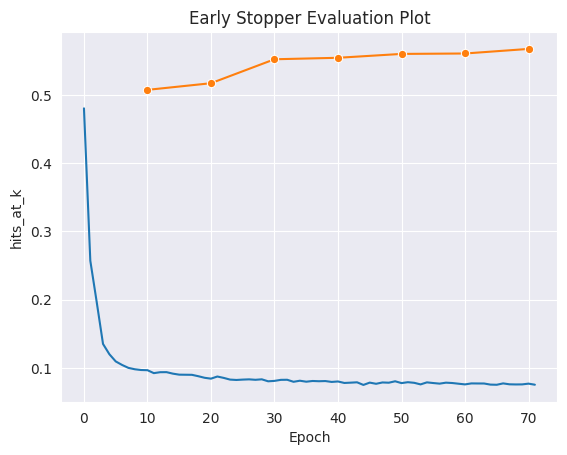

In [41]:
%%time

training, testing, validation = tf.split([.8, .1, .1])

result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model="TransR",
    model_kwargs=dict(embedding_dim=50),
    training_loop='sLCWA',
    negative_sampler='basic',
    stopper="early",
    random_seed=42,
    epochs=72,  # short epochs for testing - you should go
                # higher, especially with early stopper enabled
                
)

# result.save_to_directory(f"{kge_dir}/one50_unstratified_stopped_transe")
result.save_to_directory(f"{kge_dir}/{modelKGE}")

#model used TransE has only one representation for entities and relations, 
# so modules objects will be of length 1
print(result.model)
result.plot_losses()
result.plot_early_stopping()

In [16]:
try:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl")
except RuntimeError:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl",
    map_location=torch.device("cpu"))

print(trained_model)

TransR(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): TransRInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(2507, 50)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(23, 30)
    )
    (1): Embedding(
      (_embeddings): Embedding(23, 1500)
    )
  )
  (weight_regularizers): ModuleList()
)


## Metadata


In [17]:
import json
with open(f"{data_dir}/customLRT_KGEtransr_entityIDS.json") as infile:
    entityIDS = json.load(infile)

with open(f"{data_dir}/customLRT_KGEtransr_relationIDS.json") as infile:
    relationIDS = json.load(infile)

In [18]:
PathDict = pd.read_csv(f"{data_dir}/DBs/ReactomePathways.txt", sep="\t", header=None)
PathDict = PathDict.loc[PathDict[2]=="Homo sapiens",[0,1]].drop_duplicates()
PathDict = PathDict.set_index([0]).to_dict()[1]
# PathDict

In [19]:
#Metadata
mdPath2Path = pd.read_csv(f"{data_dir}/DBs/ReactomePathwaysRelation.txt", sep="\t", header=None)
mdPath2Path = mdPath2Path.loc[mdPath2Path[0].isin([
                "R-HSA-162582",#Signal transduction
                "R-HSA-5357801",#Programmed cell death
                "R-HSA-73894",#DNA repair
                "R-HSA-8953897",#Cell response to stress
                "R-HSA-1500931",#Cell-cell commns
                "R-HSA-1640170"#Cell cycle
                                                    ])].drop_duplicates()
mdPath2Path = mdPath2Path.replace(PathDict)
mdPath2Path = mdPath2Path.loc[mdPath2Path[1].isin(relationIDS.values())]
mdPath2Path = mdPath2Path.set_index([1]).reindex(index=relationIDS.values()).fillna(value="LR").reset_index()
mdPath2Path.head()

1                              0
0                     Apoptosis          Programmed Cell Death
1           Cell Cycle, Mitotic                     Cell Cycle
2    Cell junction organization        Cell-Cell communication
3  Cellular responses to stress  Cellular responses to stimuli
4      Death Receptor Signaling                             LR

In [26]:
mdEntities = pd.DataFrame(columns=["entity","pathway"])
for i in entityIDS.values():
    if any(mdPathPE.obj[2].str.contains(i)):
        for n in mdPathPE.obj.loc[mdPathPE.obj[2].str.contains(i)][5].unique():
            row = pd.Series({"entity":i, "pathway":n})
            mdEntities = pd.concat([mdEntities, row.to_frame().T])
    else:
        row = pd.Series({"entity":i})
        mdEntities = pd.concat([mdEntities, row.to_frame().T])
            
mdEntities = mdEntities.loc[mdEntities["pathway"].isin(relationIDS.values()) | mdEntities["pathway"].isna()] #Get only pathways wecare about from pur entity list
mdEntities["1stPathways"] = mdEntities["pathway"].map(mdPath2Path.set_index([1]).to_dict()[0])    
mdEntities


entity                                            pathway  \
0     AAAS                       Cellular responses to stress   
0     AAAS                                Cell Cycle, Mitotic   
0     AAAS  Signaling by Rho GTPases, Miro GTPases and RHO...   
0     AAMP             Signaling by Receptor Tyrosine Kinases   
0     AATF                           Death Receptor Signaling   
..     ...                                                ...   
0     ZW10  Signaling by Rho GTPases, Miro GTPases and RHO...   
0   ZWILCH                                Cell Cycle, Mitotic   
0   ZWILCH  Signaling by Rho GTPases, Miro GTPases and RHO...   
0    ZWINT                                Cell Cycle, Mitotic   
0    ZWINT  Signaling by Rho GTPases, Miro GTPases and RHO...   

                      1stPathways  
0   Cellular responses to stimuli  
0                      Cell Cycle  
0             Signal Transduction  
0             Signal Transduction  
0                              LR  
..                            ...  
0             Signal Transduction  
0                      Cell Cycle  
0             Signal Transduction  
0                      Cell Cycle  
0             Signal Transduction  

[4421 rows x 3 columns]

In [32]:
#Add entity type metadata
mdEntities["Ligands"] = mdEntities["entity"].isin(dLRpath["head"])
mdEntities["Receptors"] = mdEntities["entity"].isin(dLRpath["tail"])
mdEntities["Targets"] = mdEntities["entity"].isin(dRTpath["tail"])
# #DOES NOT WORK WITH PANDAS BELOW 1.5 (and collab env has 1.3.5....)
# mdEntities["EntityType"] = pd.from_dummies(mdEntities[["Ligands","Receptors","PTMs"]])
mdEntities

entity                                            pathway  \
0     AAAS                       Cellular responses to stress   
0     AAAS                                Cell Cycle, Mitotic   
0     AAAS  Signaling by Rho GTPases, Miro GTPases and RHO...   
0     AAMP             Signaling by Receptor Tyrosine Kinases   
0     AATF                           Death Receptor Signaling   
..     ...                                                ...   
0     ZW10  Signaling by Rho GTPases, Miro GTPases and RHO...   
0   ZWILCH                                Cell Cycle, Mitotic   
0   ZWILCH  Signaling by Rho GTPases, Miro GTPases and RHO...   
0    ZWINT                                Cell Cycle, Mitotic   
0    ZWINT  Signaling by Rho GTPases, Miro GTPases and RHO...   

                      1stPathways  Ligands  Receptors  Targets  
0   Cellular responses to stimuli    False      False     True  
0                      Cell Cycle    False      False     True  
0             Signal Transduction    False      False     True  
0             Signal Transduction    False      False     True  
0                              LR    False      False     True  
..                            ...      ...        ...      ...  
0             Signal Transduction    False      False     True  
0                      Cell Cycle    False      False     True  
0             Signal Transduction    False      False     True  
0                      Cell Cycle    False      False     True  
0             Signal Transduction    False      False     True  

[4421 rows x 6 columns]

### Nodes

In [33]:
#Construct nodes dataframe: detach() for now is meaningless as compute is CPU
entity_embeddings = trained_model.entity_representations[0](indices=None).detach().cpu().numpy()
dKGEnodes_50 = pd.DataFrame(entity_embeddings, index=entityIDS.values())
dKGEnodes_50

0         1         2         3         4         5         6   \
AAAS   -0.201149 -0.218883  0.020049  0.288104 -0.066969  0.170632 -0.322887   
AAMP    0.020951 -0.291592  0.138468 -0.031830  0.037229  0.097661 -0.178221   
AATF    0.085083 -0.094235 -0.017311  0.234901  0.062033 -0.097160  0.049620   
ABCC1  -0.119740 -0.185241  0.173619  0.149668 -0.315456  0.076847 -0.173103   
ABCD3  -0.112624 -0.023640 -0.127329  0.056583  0.007089  0.024257 -0.090809   
...          ...       ...       ...       ...       ...       ...       ...   
ZNRF3  -0.023284 -0.043150  0.093468  0.016122 -0.133373 -0.048538 -0.142818   
ZRANB1  0.168557 -0.082377  0.124859 -0.045588  0.080119 -0.154988 -0.111201   
ZW10   -0.043946 -0.221952  0.120424 -0.141735  0.245929  0.035207  0.069325   
ZWILCH  0.047290 -0.173978 -0.212108  0.104762 -0.099421  0.121642 -0.278216   
ZWINT  -0.017637 -0.135885 -0.310520 -0.008332 -0.202085  0.104741 -0.150910   

              7         8         9   ...        40        41        42  \
AAAS   -0.079326 -0.101365  0.022392  ...  0.053724  0.061619 -0.245615   
AAMP   -0.361847 -0.107483 -0.171954  ... -0.029712 -0.056342 -0.044399   
AATF    0.137447 -0.006073  0.163676  ...  0.206305  0.214235 -0.082344   
ABCC1  -0.193997 -0.217596 -0.176079  ...  0.227803 -0.057589 -0.114751   
ABCD3   0.040193 -0.170463  0.002029  ...  0.023380 -0.002311  0.091811   
...          ...       ...       ...  ...       ...       ...       ...   
ZNRF3   0.142023  0.080462  0.110987  ... -0.196290  0.121376  0.031408   
ZRANB1  0.090919  0.056552  0.019166  ... -0.163922  0.196450 -0.027047   
ZW10    0.133197 -0.094728  0.343620  ... -0.114138  0.186758 -0.090189   
ZWILCH  0.059533 -0.235186  0.136705  ... -0.103069  0.245683 -0.171601   
ZWINT  -0.206479 -0.097558  0.026735  ...  0.027987 -0.046807 -0.070574   

              43        44        45        46        47        48        49  
AAAS   -0.110809  0.073288 -0.063230 -0.073141 -0.029983 -0.189481 -0.039863  
AAMP   -0.103038 -0.104707  0.109106  0.094820 -0.108496  0.069959 -0.043669  
AATF   -0.094646 -0.146063  0.066738  0.252404 -0.203899 -0.296347 -0.032439  
ABCC1  -0.017054 -0.018978  0.033963  0.081139 -0.015416 -0.249233  0.108095  
ABCD3   0.071431 -0.063530 -0.006602 -0.071628 -0.168155 -0.240646 -0.123966  
...          ...       ...       ...       ...       ...       ...       ...  
ZNRF3  -0.052333  0.071770  0.071192  0.161012  0.143996  0.084458  0.266876  
ZRANB1 -0.145925  0.053214  0.039090  0.064877  0.120903 -0.099010  0.097119  
ZW10    0.019934  0.140588  0.194385  0.149962 -0.198785  0.053518 -0.238291  
ZWILCH  0.266093 -0.068662  0.198846 -0.146907  0.177667 -0.038137 -0.133198  
ZWINT   0.229264  0.080274  0.108494  0.103343  0.197323 -0.152950 -0.059263  

[2507 rows x 50 columns]

In [34]:
l_and_r = pd.Series(entityIDS.values()).isin((mdEntities.loc[mdEntities["Ligands"]==True,"entity"])) & pd.Series(entityIDS.values()).isin((mdEntities.loc[mdEntities["Receptors"]==True,"entity"]))
print(l_and_r.describe())
l_and_r
# l_and_r_mask = np.array([0]*len(nodes))
# l_and_r_mask[l_and_r] = 1

count      2507
unique        2
top       False
freq       2486
dtype: object


0       False
1       False
2       False
3       False
4       False
        ...  
2502    False
2503    False
2504    False
2505    False
2506    False
Length: 2507, dtype: bool

In [35]:
deg = dict(networkx.degree(G))
deg = pd.DataFrame((deg.keys(), deg.values())).T
deg.set_index(0, inplace=True)
deg = deg.loc[np.array(G.nodes())].reindex(entityIDS.values())
deg[1] = deg[1].astype(float)
logdeg = deg.copy(deep=True)
logdeg[1] = np.log10(logdeg[1]) #NP.log needs floats and can't take in int.
deg[1] = deg[1].astype(int)
print(deg.describe())
print(logdeg.describe())
deg

                 1
count  2507.000000
mean     77.428799
std     119.977618
min       1.000000
25%       7.000000
50%      19.000000
75%      77.500000
max    1716.000000
                 1
count  2507.000000
mean      1.399946
std       0.681866
min       0.000000
25%       0.845098
50%       1.278754
75%       1.889293
max       3.234517


1
0         
AAAS    18
AAMP    39
AATF    11
ABCC1    4
ABCD3   14
...     ..
ZNRF3   19
ZRANB1  19
ZW10    14
ZWILCH  14
ZWINT   14

[2507 rows x 1 columns]

## DR on KGE

In [36]:
from sklearn.decomposition import PCA

dKGEn_pca = PCA(n_components=2).fit_transform(dKGEnodes_50)
dKGEn_pca = pd.DataFrame(dKGEn_pca, index=entityIDS.values())

/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: title={'center': 'KGE nodes (col=Degree)'}, xlabel='PC-1', ylabel='PC-2'>

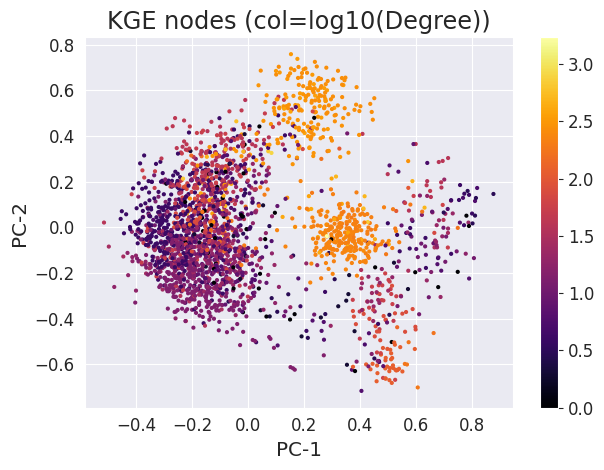

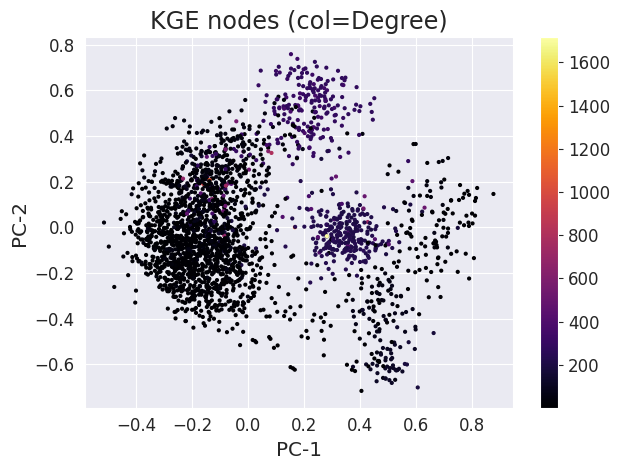

In [54]:
scprep.plot.scatter2d(dKGEn_pca,
    c=logdeg, #cmap_scale = "log", SCALE STUCK AT BOTTOM BLACK END
    title="KGE nodes (col=log10(Degree))", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)
scprep.plot.scatter2d(dKGEn_pca,
    c=deg, #cmap_scale = "log", SCALE STUCK AT BOTTOM BLACK END
    title="KGE nodes (col=Degree)", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)

/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: title={'center': 'KGE nodes (col=Targets)'}, xlabel='PC-1', ylabel='PC-2'>

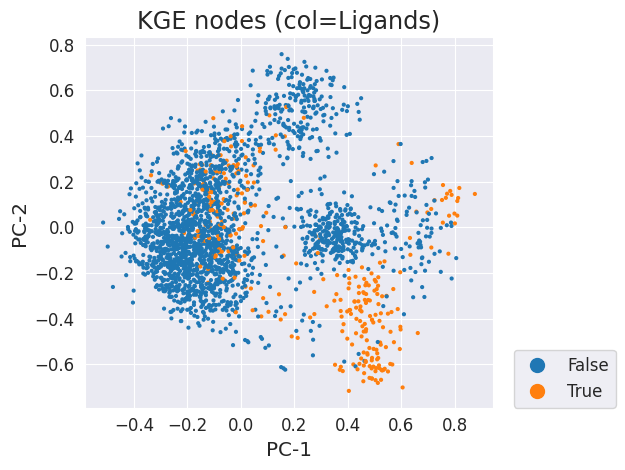

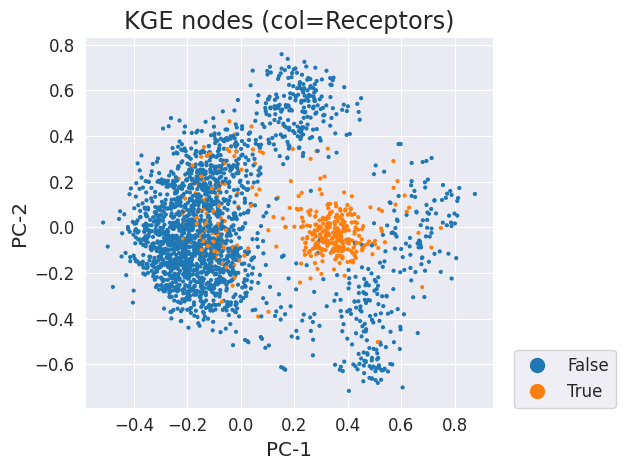

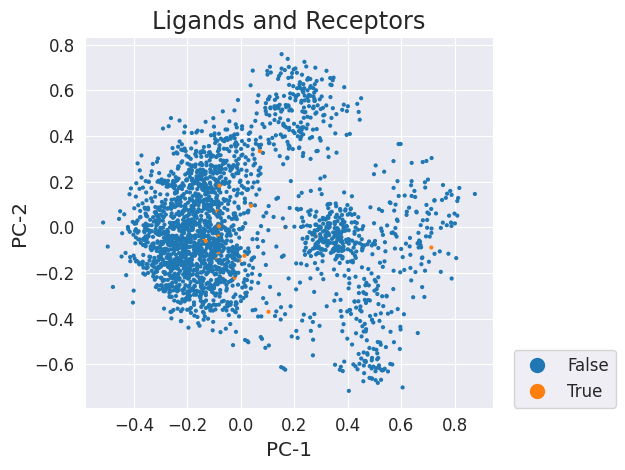

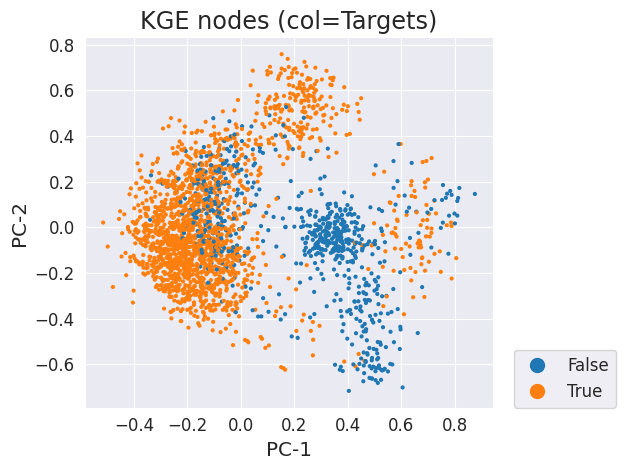

In [57]:
scprep.plot.scatter2d(dKGEn_pca,
    c=dKGEn_pca.index.isin(mdEntities.loc[mdEntities["Ligands"]==True, "entity"]),
    title="KGE nodes (col=Ligands)", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)
scprep.plot.scatter2d(dKGEn_pca,
    c=dKGEn_pca.index.isin(mdEntities.loc[mdEntities["Receptors"]==True, "entity"]),
    title="KGE nodes (col=Receptors)", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)
scprep.plot.scatter2d(dKGEn_pca,
    c=l_and_r,
    title="Ligands and Receptors", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)
scprep.plot.scatter2d(dKGEn_pca,
    c=dKGEn_pca.index.isin(mdEntities.loc[mdEntities["Targets"]==True, "entity"]),
    title="KGE nodes (col=Targets)", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)

/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/hom

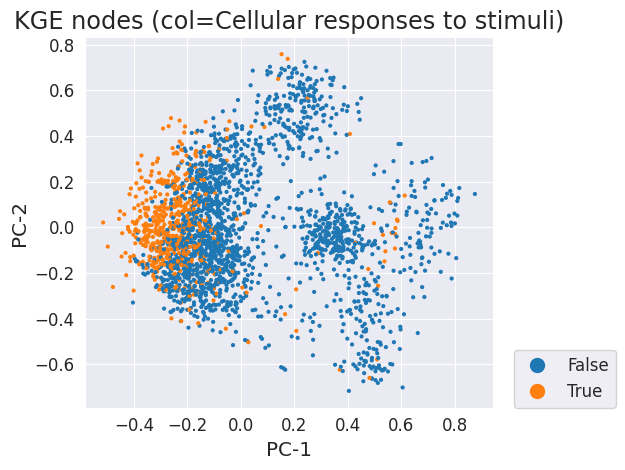

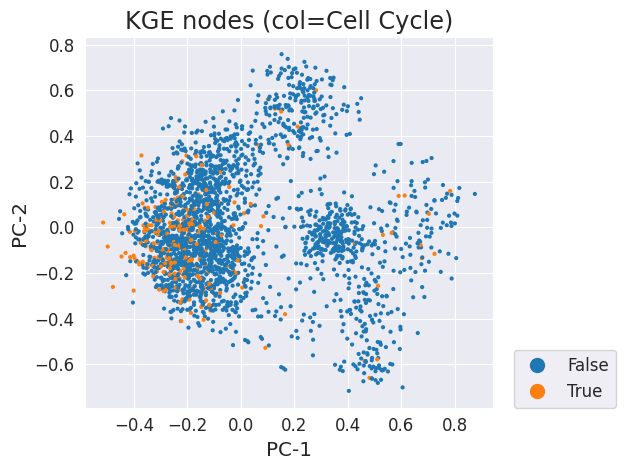

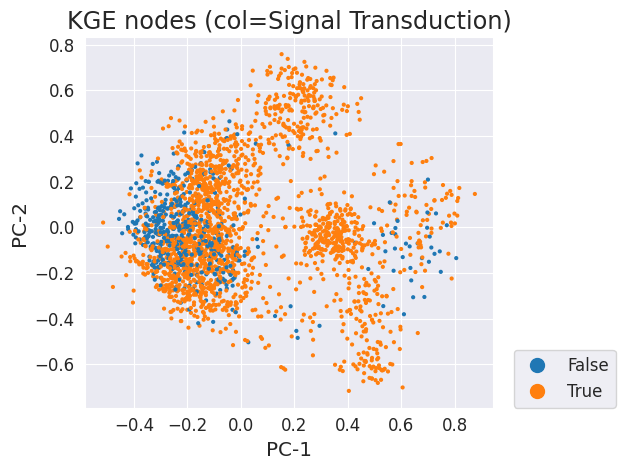

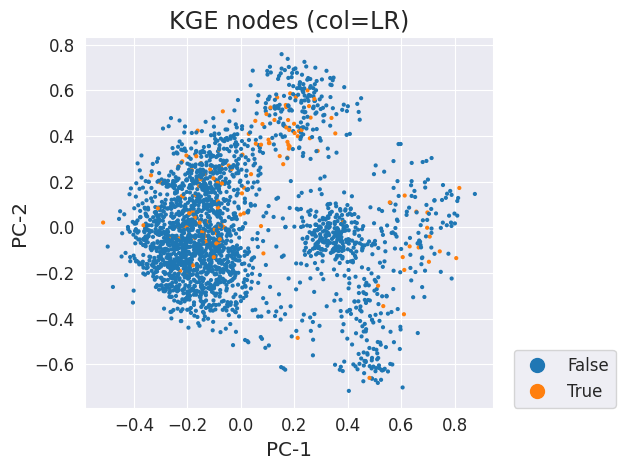

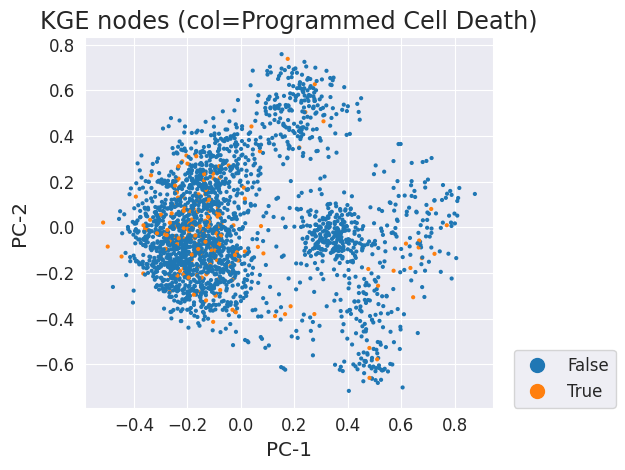

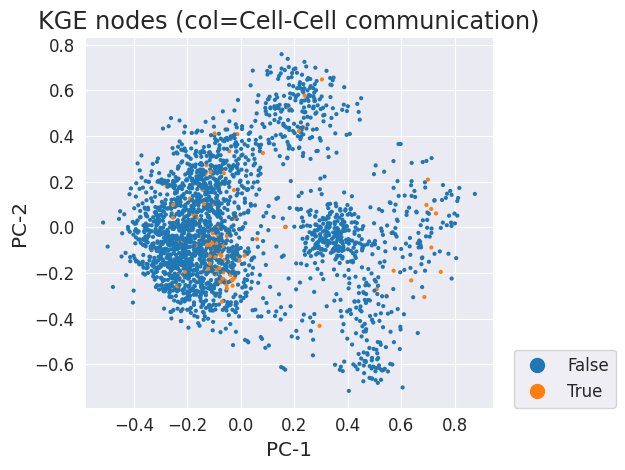

In [58]:
for i in mdEntities["1stPathways"].dropna().unique():
    scprep.plot.scatter2d(dKGEn_pca,
        c=dKGEn_pca.index.isin(mdEntities.loc[mdEntities["1stPathways"]==i, "entity"]),
        title=f"KGE nodes (col={i})", label_prefix="PC-", 
        legend_loc=(1.05, 0), shuffle=True,
        dpi=480)

In [37]:
dKGEn_phate = phate.PHATE(random_state=12).fit_transform(dKGEnodes_50)
dKGEn_phate = pd.DataFrame(dKGEn_phate, index=entityIDS.values())

Calculating PHATE...
  Running PHATE on 2507 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.63 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.66 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.22 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.35 seconds.
  Calculated landmark operator in 5.58 seconds.
  Calculating optimal t...
    Automatically selected t = 35
  Calculated optimal t in 1.41 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.82 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.61 seconds.
Calculated PHATE in 14.08 seconds.


/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


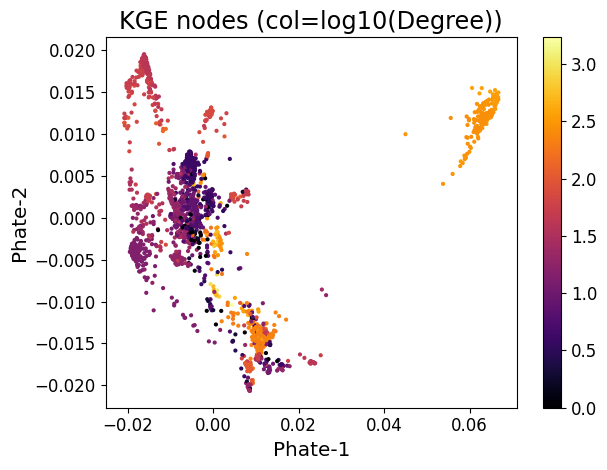

In [62]:
scprep.plot.scatter2d(dKGEn_phate,
    c=logdeg, #cmap_scale = "log", SCALE STUCK AT BOTTOM BLACK END
    title="KGE nodes (col=log10(Degree))", label_prefix="Phate-", 
    legend_loc=(1.05, 0), shuffle=True, #figsize=[8,8],
    dpi=480)
# scprep.plot.scatter2d(dKGEn_phate,
#     c=deg, #cmap_scale = "log", SCALE STUCK AT BOTTOM BLACK END
#     title="KGE nodes (col=Degree)", label_prefix="Phate-", 
#     legend_loc=(1.05, 0), shuffle=True,
#     dpi=480)

plt.savefig("LRT_KGE.pdf")

/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


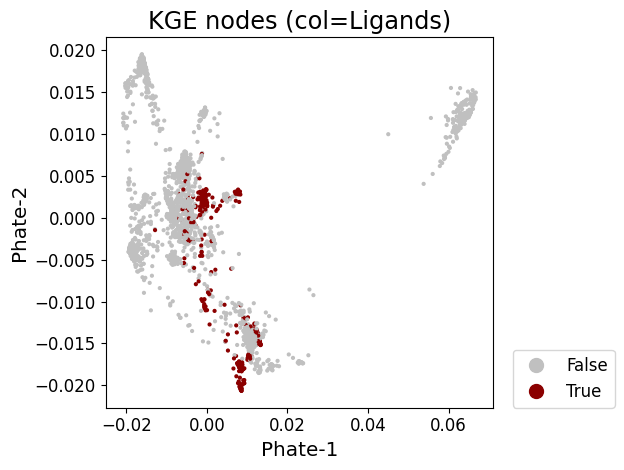

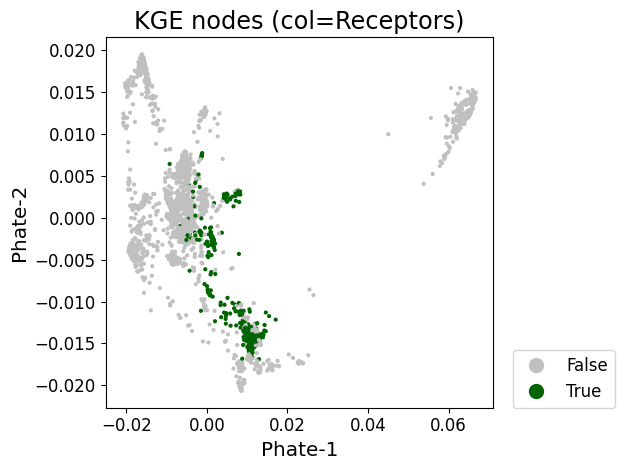

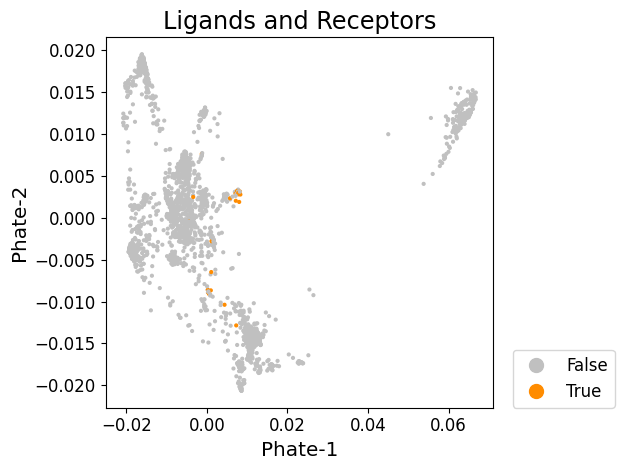

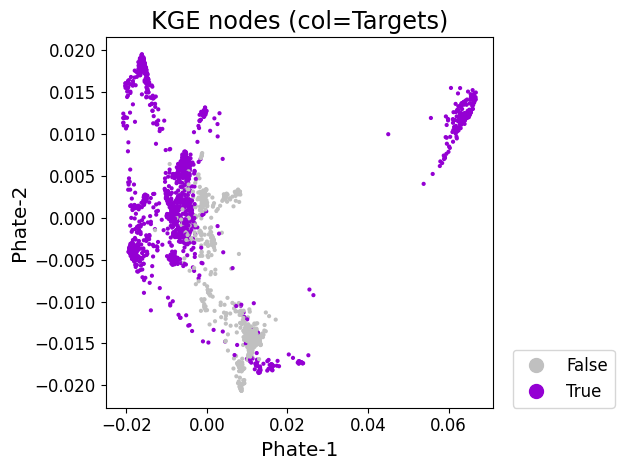

In [45]:
scprep.plot.scatter2d(dKGEn_phate,
    c=dKGEn_phate.index.isin(mdEntities.loc[mdEntities["Ligands"]==True, "entity"]),
    title="KGE nodes (col=Ligands)", label_prefix="Phate-", 
    legend_loc=(1.05, 0), shuffle=True, cmap = ["silver","darkred"],
    dpi=480)
plt.savefig("LRT_KGE_lig.pdf")
scprep.plot.scatter2d(dKGEn_phate,
    c=dKGEn_phate.index.isin(mdEntities.loc[mdEntities["Receptors"]==True, "entity"]),
    title="KGE nodes (col=Receptors)", label_prefix="Phate-", 
    legend_loc=(1.05, 0), shuffle=True, cmap = ["silver","darkgreen"],
    dpi=480)
plt.savefig("LRT_KGE_rec.pdf")
scprep.plot.scatter2d(dKGEn_phate,
    c=l_and_r,
    title="Ligands and Receptors", label_prefix="Phate-", 
    legend_loc=(1.05, 0), shuffle=True, cmap = ["silver","darkorange"],
    dpi=480)
scprep.plot.scatter2d(dKGEn_phate,
    c=dKGEn_phate.index.isin(mdEntities.loc[mdEntities["Targets"]==True, "entity"]),
    title="KGE nodes (col=Targets)", label_prefix="Phate-", 
    legend_loc=(1.05, 0), shuffle=True, cmap = ["silver","darkviolet"],
    dpi=480)
plt.savefig("LRT_KGE_tar.pdf")

/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/hom

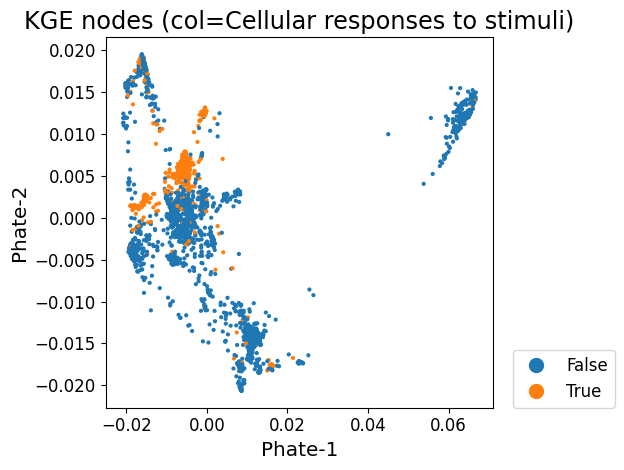

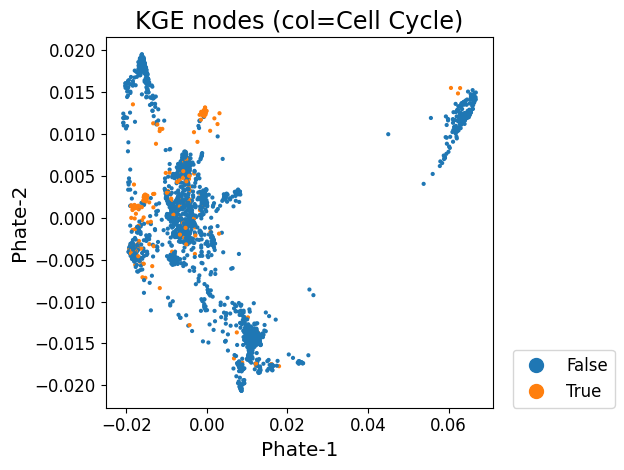

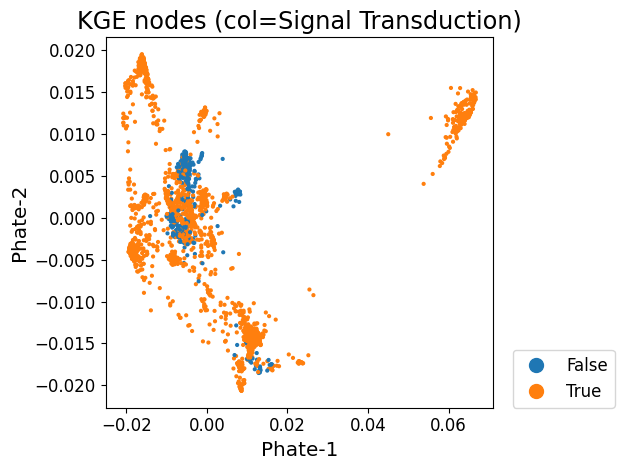

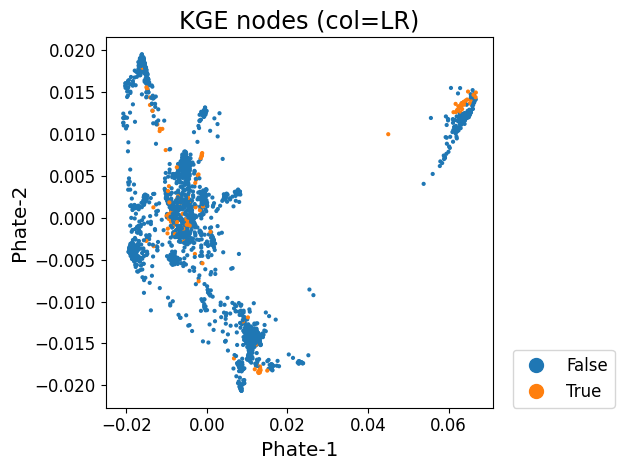

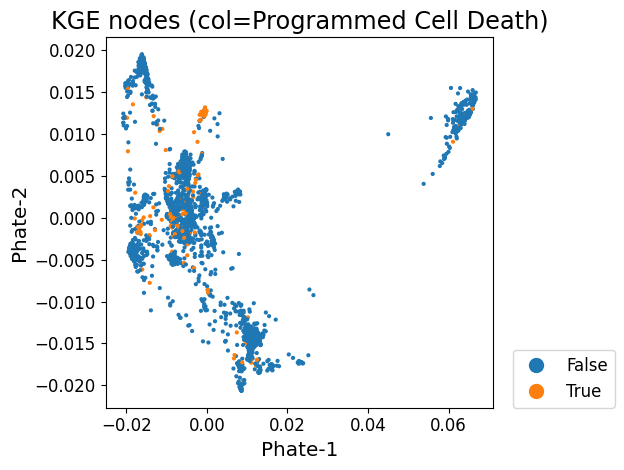

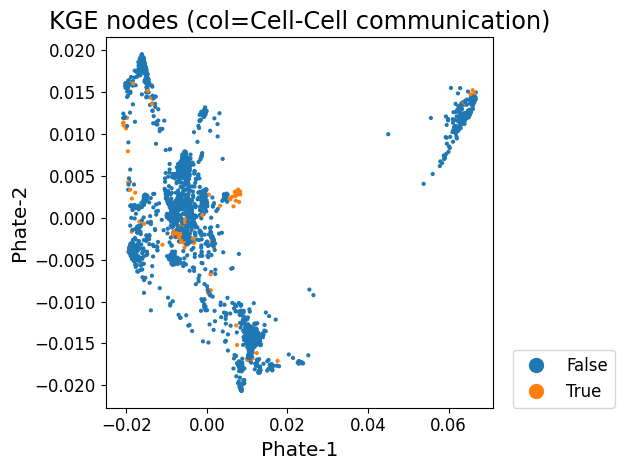

In [46]:
for i in mdEntities["1stPathways"].dropna().unique():
    scprep.plot.scatter2d(dKGEn_phate,
        c=dKGEn_phate.index.isin(mdEntities.loc[mdEntities["1stPathways"]==i, "entity"]),
        title=f"KGE nodes (col={i})", label_prefix="Phate-", 
        legend_loc=(1.05, 0), shuffle=True,
        dpi=480)

In [63]:
list(mdPath2Path.loc[mdPath2Path[0]=="Signal Transduction",1])

['Death Receptor Signalling',
 'Integrin signaling',
 'Intracellular signaling by second messengers',
 'MAPK family signaling cascades',
 'Signaling by Erythropoietin',
 'Signaling by GPCR',
 'Signaling by Hedgehog',
 'Signaling by Leptin',
 'Signaling by NOTCH',
 'Signaling by Non-Receptor Tyrosine Kinases',
 'Signaling by Nuclear Receptors',
 'Signaling by Receptor Tyrosine Kinases',
 'Signaling by Rho GTPases, Miro GTPases and RHOBTB3',
 'Signaling by TGFB family members',
 'Signaling by WNT']

/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/hom

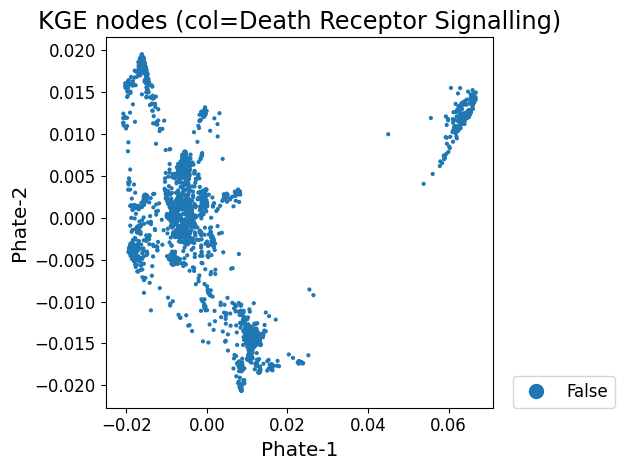

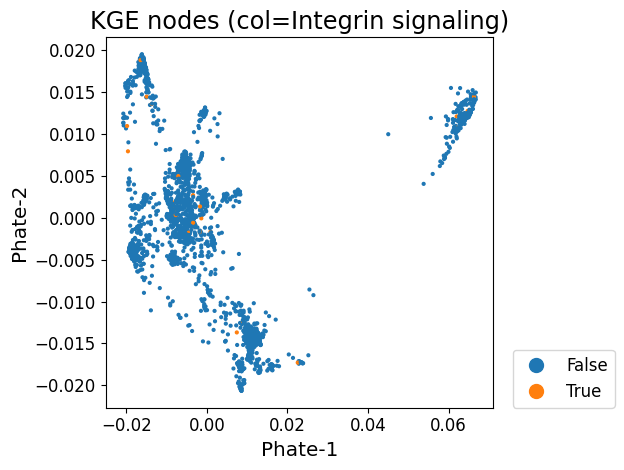

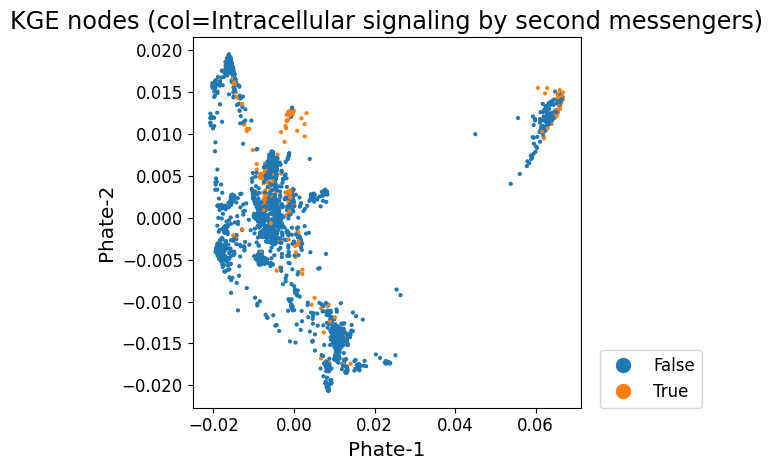

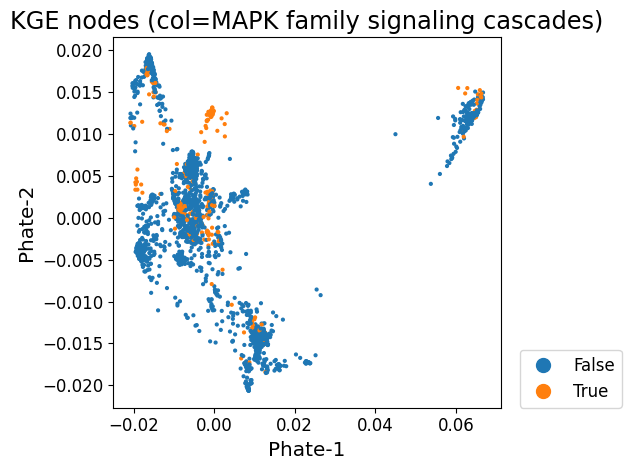

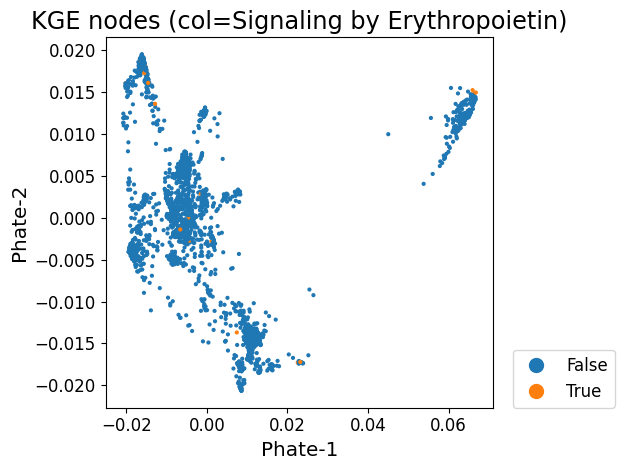

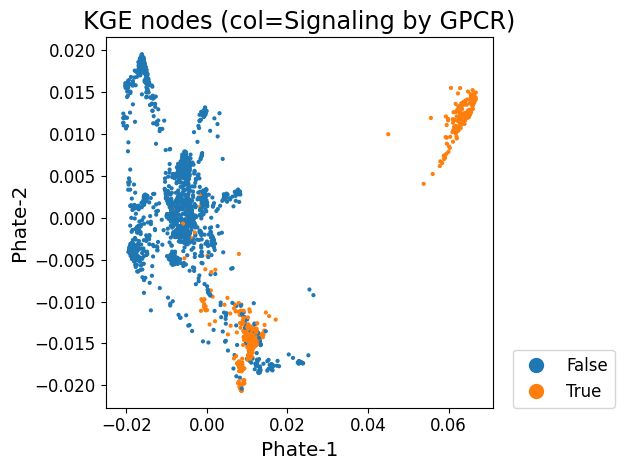

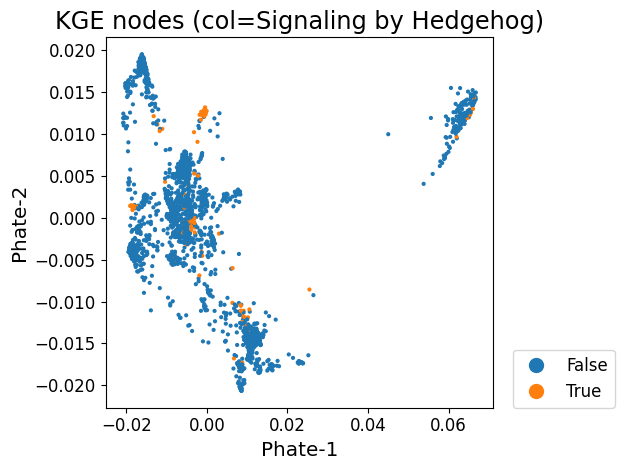

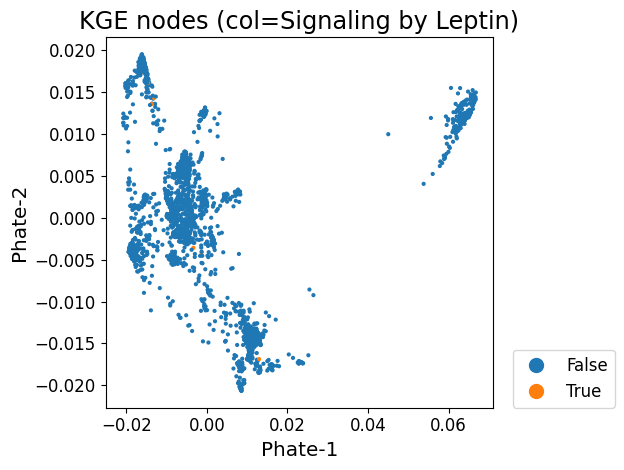

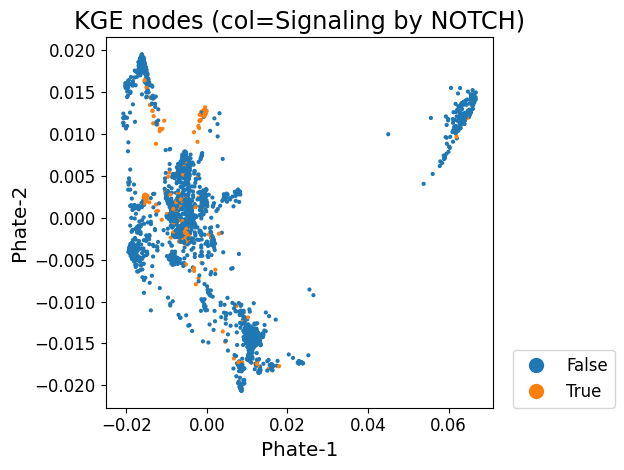

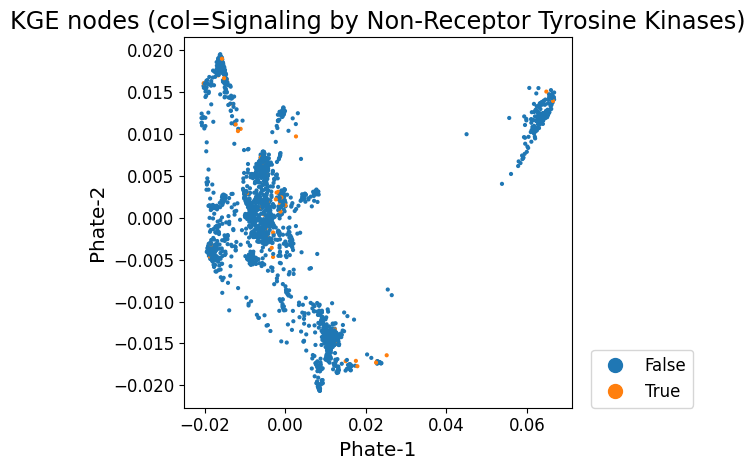

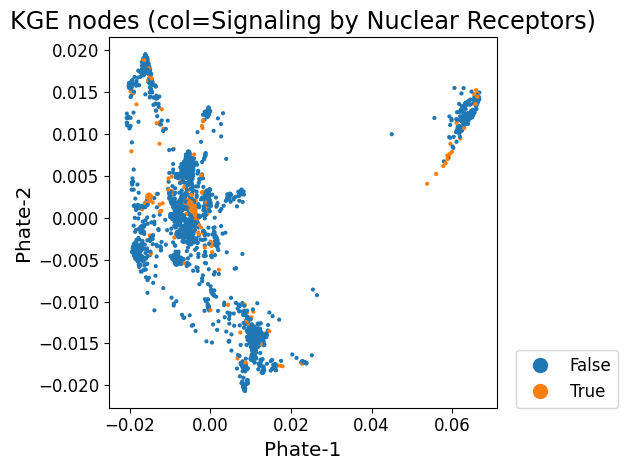

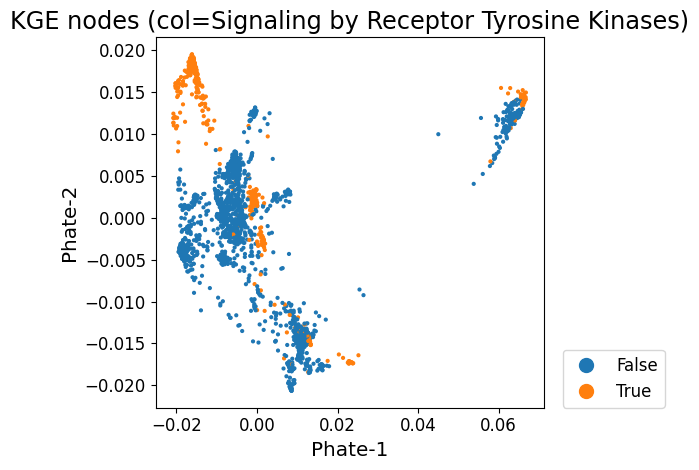

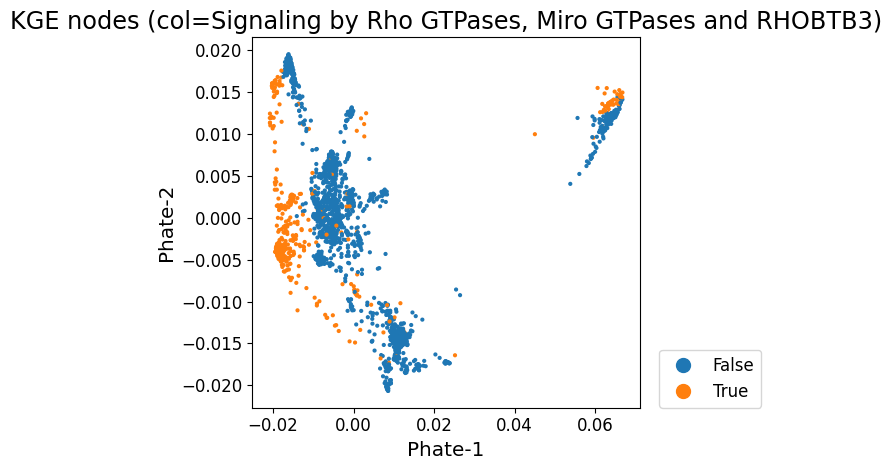

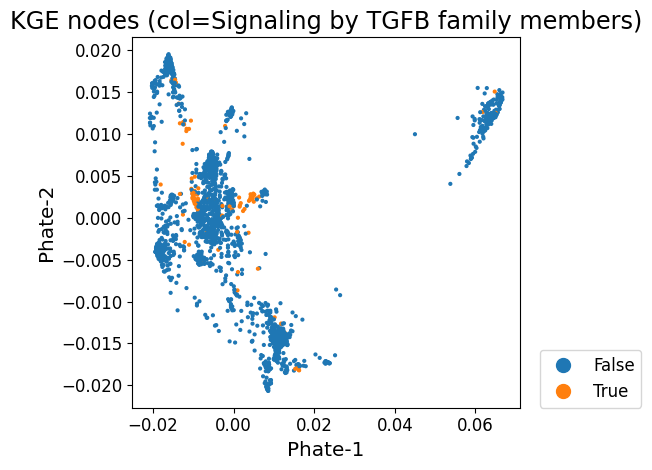

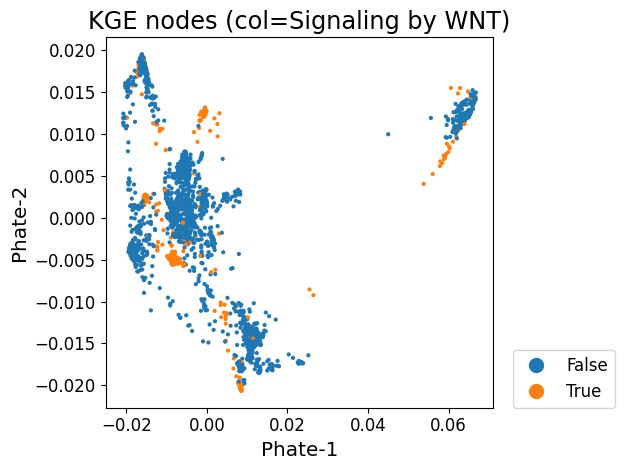

In [48]:
for i in mdPath2Path.loc[mdPath2Path[0]=="Signal Transduction",1]:
    scprep.plot.scatter2d(dKGEn_phate,
        c=dKGEn_phate.index.isin(mdEntities.loc[mdEntities["pathway"]==i, "entity"]),
        title=f"KGE nodes (col={i})", label_prefix="Phate-", 
        legend_loc=(1.05, 0), shuffle=True,
        dpi=480)
    plt.savefig(f"LRT_KGE_{i}.pdf")

## Edge metadata



In [50]:
trained_model.relation_representations[0](indices=None).detach().cpu().numpy().shape

(23, 30)

In [51]:
relationIDS.values()

dict_values(['Apoptosis', 'Cell Cycle, Mitotic', 'Cell junction organization', 'Cellular responses to stress', 'Death Receptor Signaling', 'Death Receptor Signalling', 'Integrin signaling', 'Intracellular signaling by second messengers', 'MAPK family signaling cascades', 'Nephrin family interactions', 'Regulated Necrosis', 'Signal regulatory protein family interactions', 'Signaling by Erythropoietin', 'Signaling by GPCR', 'Signaling by Hedgehog', 'Signaling by Leptin', 'Signaling by NOTCH', 'Signaling by Non-Receptor Tyrosine Kinases', 'Signaling by Nuclear Receptors', 'Signaling by Receptor Tyrosine Kinases', 'Signaling by Rho GTPases, Miro GTPases and RHOBTB3', 'Signaling by TGFB family members', 'Signaling by WNT'])

In [52]:
#Construct edges dataframe
relation_embeddings = trained_model.relation_representations[0](indices=None).detach().cpu().numpy()
dKGEedges_50 = pd.DataFrame(relation_embeddings, index=relationIDS.values())
dKGEedges_50

0         1   \
Apoptosis                                           0.264806 -0.030401   
Cell Cycle, Mitotic                                -0.096847 -0.018950   
Cell junction organization                         -0.198483 -0.018579   
Cellular responses to stress                        0.008602 -0.055394   
Death Receptor Signaling                           -0.021388 -0.030478   
Death Receptor Signalling                          -0.078782 -0.152841   
Integrin signaling                                 -0.275038  0.126515   
Intracellular signaling by second messengers       -0.227834  0.001653   
MAPK family signaling cascades                      0.168743  0.060725   
Nephrin family interactions                         0.284857 -0.087532   
Regulated Necrosis                                  0.303057  0.092923   
Signal regulatory protein family interactions       0.048245  0.109830   
Signaling by Erythropoietin                        -0.096187  0.213293   
Signaling by GPCR                                  -0.127944 -0.279573   
Signaling by Hedgehog                               0.083148  0.307395   
Signaling by Leptin                                 0.033165 -0.328824   
Signaling by NOTCH                                  0.077429  0.104516   
Signaling by Non-Receptor Tyrosine Kinases          0.146182  0.241519   
Signaling by Nuclear Receptors                     -0.078191 -0.053124   
Signaling by Receptor Tyrosine Kinases              0.066867  0.215999   
Signaling by Rho GTPases, Miro GTPases and RHOBTB3 -0.191873  0.028144   
Signaling by TGFB family members                   -0.122536 -0.089936   
Signaling by WNT                                   -0.232666  0.255114   

                                                          2         3   \
Apoptosis                                           0.024688  0.244462   
Cell Cycle, Mitotic                                -0.212290 -0.033764   
Cell junction organization                         -0.051476  0.283889   
Cellular responses to stress                       -0.242059  0.307129   
Death Receptor Signaling                           -0.267534  0.245033   
Death Receptor Signalling                          -0.185116 -0.145701   
Integrin signaling                                 -0.160028  0.262762   
Intracellular signaling by second messengers       -0.264663  0.288449   
MAPK family signaling cascades                     -0.046711  0.268571   
Nephrin family interactions                        -0.203928 -0.026953   
Regulated Necrosis                                 -0.293409  0.070564   
Signal regulatory protein family interactions       0.048328 -0.302384   
Signaling by Erythropoietin                         0.097205  0.013413   
Signaling by GPCR                                   0.094141  0.120473   
Signaling by Hedgehog                               0.002563 -0.014292   
Signaling by Leptin                                 0.060391  0.015305   
Signaling by NOTCH                                 -0.034467  0.110636   
Signaling by Non-Receptor Tyrosine Kinases          0.120522  0.151471   
Signaling by Nuclear Receptors                     -0.244964 -0.040282   
Signaling by Receptor Tyrosine Kinases              0.103372 -0.173623   
Signaling by Rho GTPases, Miro GTPases and RHOBTB3  0.192808 -0.222555   
Signaling by TGFB family members                   -0.284438 -0.112582   
Signaling by WNT                                   -0.221544 -0.232726   

                                                          4         5   \
Apoptosis                                          -0.012316  0.314249   
Cell Cycle, Mitotic                                 0.174347 -0.233981   
Cell junction organization                          0.089848  0.035377   
Cellular responses to stress                        0.132005  0.067178   
Death Receptor Signaling                           -0.071459 -0.018895   
Death Receptor Signalling                           0.214250

### PCA

In [53]:
from sklearn.decomposition import PCA

dKGEe_pca = PCA(n_components=2).fit_transform(dKGEedges_50)
dKGEe_pca = pd.DataFrame(dKGEe_pca, index=relationIDS.values())

In [54]:
mdPath2Path.set_index([1]).reindex(relationIDS.values())

0
1                                                                                
Apoptosis                                                   Programmed Cell Death
Cell Cycle, Mitotic                                                    Cell Cycle
Cell junction organization                                Cell-Cell communication
Cellular responses to stress                        Cellular responses to stimuli
Death Receptor Signaling                                                       LR
Death Receptor Signalling                                     Signal Transduction
Integrin signaling                                            Signal Transduction
Intracellular signaling by second messengers                  Signal Transduction
MAPK family signaling cascades                                Signal Transduction
Nephrin family interactions                               Cell-Cell communication
Regulated Necrosis                                          Programmed Cell Death
Signal regulatory protein family interactions             Cell-Cell communication
Signaling by Erythropoietin                                   Signal Transduction
Signaling by GPCR                                             Signal Transduction
Signaling by Hedgehog                                         Signal Transduction
Signaling by Leptin                                           Signal Transduction
Signaling by NOTCH                                            Signal Transduction
Signaling by Non-Receptor Tyrosine Kinases                    Signal Transduction
Signaling by Nuclear Receptors                                Signal Transduction
Signaling by Receptor Tyrosine Kinases                        Signal Transduction
Signaling by Rho GTPases, Miro GTPases and RHOBTB3            Signal Transduction
Signaling by TGFB family members                              Signal Transduction
Signaling by WNT                                              Signal Transduction

/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:99: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: title={'center': 'Edges'}, xlabel='PC-1', ylabel='PC-2'>

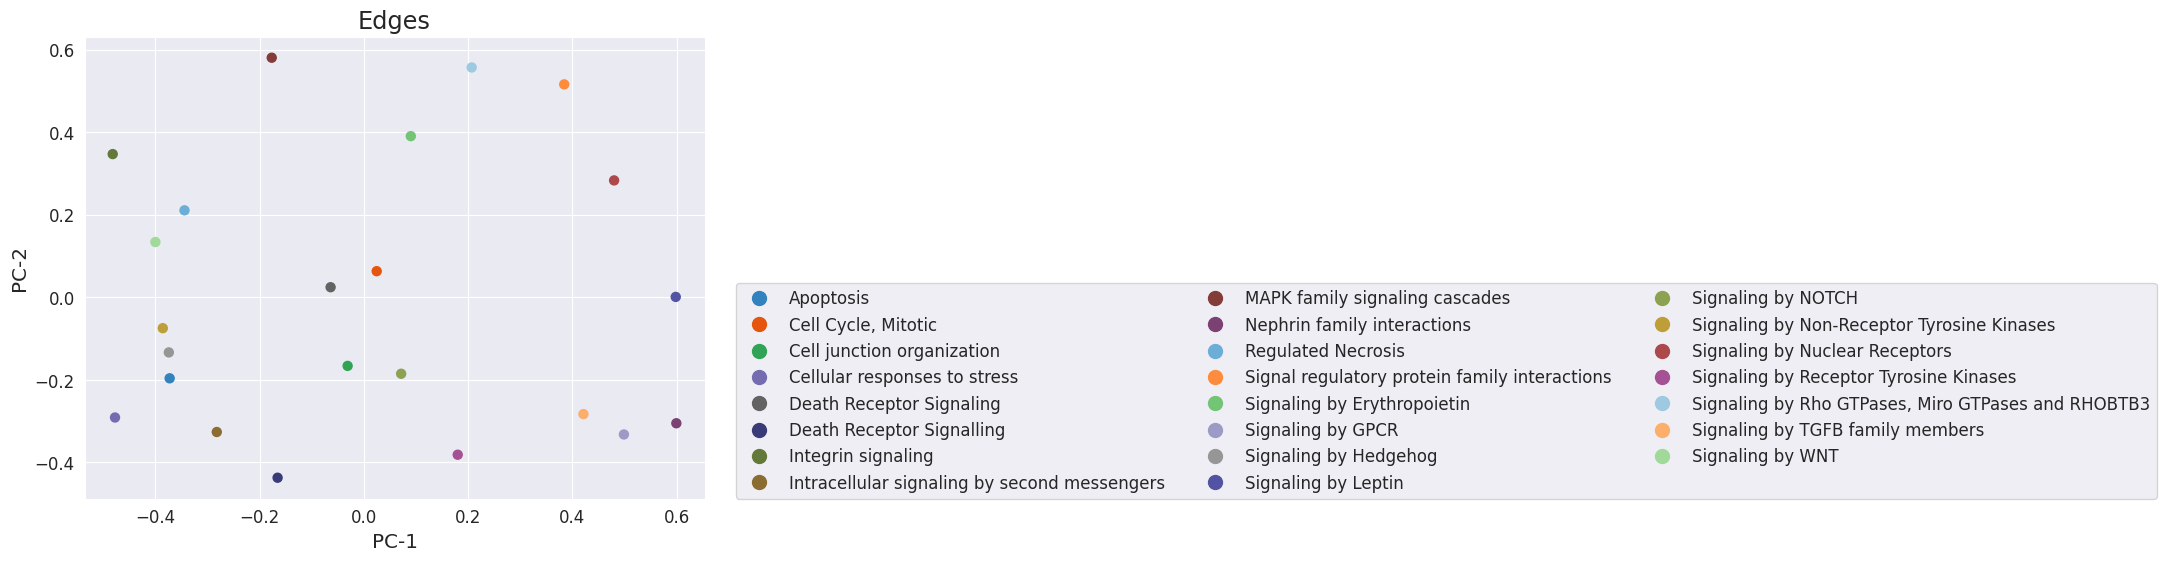

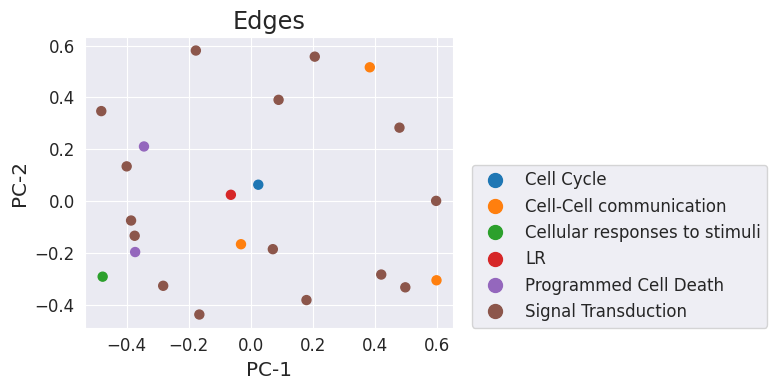

In [70]:
scprep.plot.scatter2d(dKGEe_pca,
    c=dKGEe_pca.index,
    title="Edges", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    figsize=(8, 6),dpi=480)
scprep.plot.scatter2d(dKGEe_pca,
    c=mdPath2Path.set_index([1]).reindex(relationIDS.values()),
    title="Edges", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    figsize=(8, 4),dpi=480)

### PHATE

In [71]:
dKGEe_phate = phate.PHATE().fit_transform(dKGEedges_50)
dKGEe_phate = pd.DataFrame(dKGEe_phate, index=relationIDS.values())

Calculating PHATE...
  Running PHATE on 23 observations and 30 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 10
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.02 seconds.


/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:99: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/home/ferran/miniconda3/envs/collab/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: title={'center': 'Edges'}, xlabel='PHATE-1', ylabel='PHATE-2'>

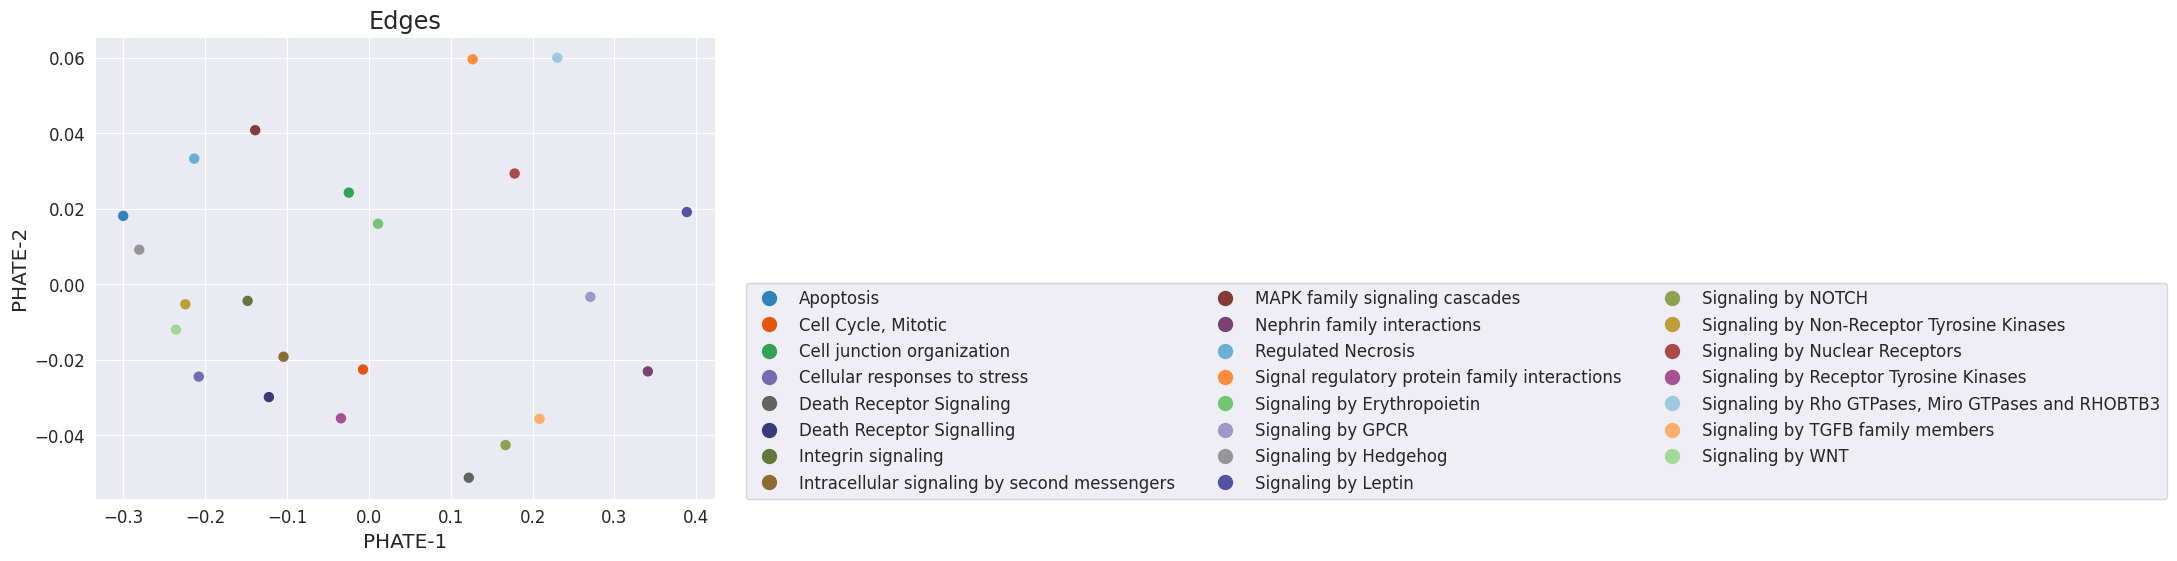

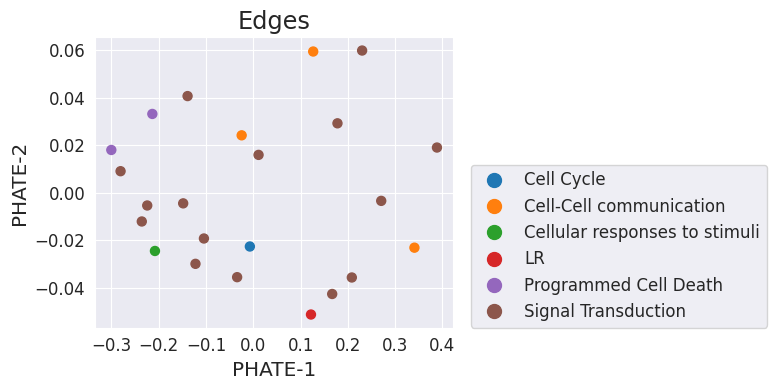

In [72]:
scprep.plot.scatter2d(dKGEe_phate,
    c=dKGEe_phate.index,
    title="Edges", label_prefix="PHATE-", 
    legend_loc=(1.05, 0), shuffle=True,
    figsize=(8, 6),dpi=480)
scprep.plot.scatter2d(dKGEe_phate,
    c=mdPath2Path.set_index([1]).reindex(relationIDS.values()),
    title="Edges", label_prefix="PHATE-", 
    legend_loc=(1.05, 0), shuffle=True,
    figsize=(8, 4),dpi=480)